In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pylab
import scipy.stats as stats
import warnings
import os

%matplotlib inline
warnings.filterwarnings("ignore")

Executive Summary

The comp-activ database comprises activity measures of computer systems. Data was gathered from a Sun Sparcstation 20/712 with 128 Mbytes of memory, operating in a multi-user university department. Users engaged in diverse tasks, such as internet access, file editing, and CPU-intensive programs.

Aim: To establish a linear equation for predicting 'usr' (the percentage of time CPUs operate in user mode). Also, to analyze various system attributes to understand their influence on the system's 'usr' mode.

In [2]:
df = pd.read_excel('compactiv.xlsx')
df.head()

lread  lwrite  scall  sread  swrite  fork  exec    rchar    wchar  pgout  \
0      1       0   2147     79      68   0.2   0.2  40671.0  53995.0    0.0   
1      0       0    170     18      21   0.2   0.2    448.0   8385.0    0.0   
2     15       3   2162    159     119   2.0   2.4      NaN  31950.0    0.0   
3      0       0    160     12      16   0.2   0.2      NaN   8670.0    0.0   
4      5       1    330     39      38   0.4   0.4      NaN  12185.0    0.0   

   ...  pgscan  atch  pgin  ppgin    pflt    vflt         runqsz  freemem  \
0  ...     0.0   0.0   1.6    2.6   16.00   26.40      CPU_Bound     4670   
1  ...     0.0   0.0   0.0    0.0   15.63   16.83  Not_CPU_Bound     7278   
2  ...     0.0   1.2   6.0    9.4  150.20  220.20  Not_CPU_Bound      702   
3  ...     0.0   0.0   0.2    0.2   15.60   16.80  Not_CPU_Bound     7248   
4  ...     0.0   0.0   1.0    1.2   37.80   47.60  Not_CPU_Bound      633   

  freeswap  usr  
0  1730946   95  
1  1869002   97  
2  1021237   87  
3  1863704   98  
4  1760253   90  

[5 rows x 22 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lread     8192 non-null   int64  
 1   lwrite    8192 non-null   int64  
 2   scall     8192 non-null   int64  
 3   sread     8192 non-null   int64  
 4   swrite    8192 non-null   int64  
 5   fork      8192 non-null   float64
 6   exec      8192 non-null   float64
 7   rchar     8088 non-null   float64
 8   wchar     8177 non-null   float64
 9   pgout     8192 non-null   float64
 10  ppgout    8192 non-null   float64
 11  pgfree    8192 non-null   float64
 12  pgscan    8192 non-null   float64
 13  atch      8192 non-null   float64
 14  pgin      8192 non-null   float64
 15  ppgin     8192 non-null   float64
 16  pflt      8192 non-null   float64
 17  vflt      8192 non-null   float64
 18  runqsz    8192 non-null   object 
 19  freemem   8192 non-null   int64  
 20  freeswap  8192 non-null   int6

The data consists of 8192 records and 22 fetures. 21 features belong to the numerical data type and 1 feture belong to Object data type which shall be later converted to numerical category. However, there are missing records in rchar and wchar variables 

In [4]:
df_uni = df.drop('runqsz', axis=1)
df_uni.describe().T

count          mean            std     min        25%        50%  \
lread     8192.0  1.955969e+01      53.353799     0.0        2.0        7.0   
lwrite    8192.0  1.310620e+01      29.891726     0.0        0.0        1.0   
scall     8192.0  2.306318e+03    1633.617322   109.0     1012.0     2051.5   
sread     8192.0  2.104800e+02     198.980146     6.0       86.0      166.0   
swrite    8192.0  1.500582e+02     160.478980     7.0       63.0      117.0   
fork      8192.0  1.884554e+00       2.479493     0.0        0.4        0.8   
exec      8192.0  2.791998e+00       5.212456     0.0        0.2        1.2   
rchar     8088.0  1.973857e+05  239837.493526   278.0    34091.5   125473.5   
wchar     8177.0  9.590299e+04  140841.707911  1498.0    22916.0    46619.0   
pgout     8192.0  2.285317e+00       5.307038     0.0        0.0        0.0   
ppgout    8192.0  5.977229e+00      15.214590     0.0        0.0        0.0   
pgfree    8192.0  1.191971e+01      32.363520     0.0        0.0        0.0   
pgscan    8192.0  2.152685e+01      71.141340     0.0        0.0        0.0   
atch      8192.0  1.127505e+00       5.708347     0.0        0.0        0.0   
pgin      8192.0  8.277960e+00      13.874978     0.0        0.6        2.8   
ppgin     8192.0  1.238859e+01      22.281318     0.0        0.6        3.8   
pflt      8192.0  1.097938e+02     114.419221     0.0       25.0       63.8   
vflt      8192.0  1.853158e+02     191.000603     0.2       45.4      120.4   
freemem   8192.0  1.763456e+03    2482.104511    55.0      231.0      579.0   
freeswap  8192.0  1.328126e+06  422019.426957     2.0  1042623.5  1289289.5   
usr       8192.0  8.396887e+01      18.401905     0.0       81.0       89.0   

                  75%         max  
lread          20.000     1845.00  
lwrite         10.000      575.00  
scall        3317.250    12493.00  
sread         279.000     5318.00  
swrite        185.000     5456.00  
fork            2.200       20.12  
exec            2.800       59.56  
rchar      267828.750  2526649.00  
wchar      106101.000  1801623.00  
pgout           2.400       81.44  
ppgout          4.200      184.20  
pgfree          5.000      523.00  
pgscan          0.000     1237.00  
atch            0.600      211.58  
pgin            9.765      141.20  
ppgin          13.800      292.61  
pflt          159.600      899.80  
vflt          251.800     1365.00  
freemem      2002.250    12027.00  
freeswap  1730379.500  2243187.00  
usr            94.000       99.00

## Univariate Analysis

In [5]:
df.columns

Index(['lread', 'lwrite', 'scall', 'sread', 'swrite', 'fork', 'exec', 'rchar',
       'wchar', 'pgout', 'ppgout', 'pgfree', 'pgscan', 'atch', 'pgin', 'ppgin',
       'pflt', 'vflt', 'runqsz', 'freemem', 'freeswap', 'usr'],
      dtype='object')

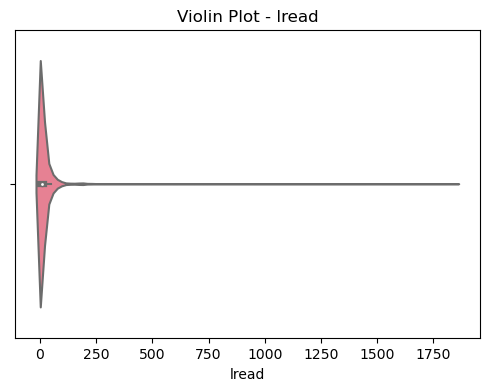

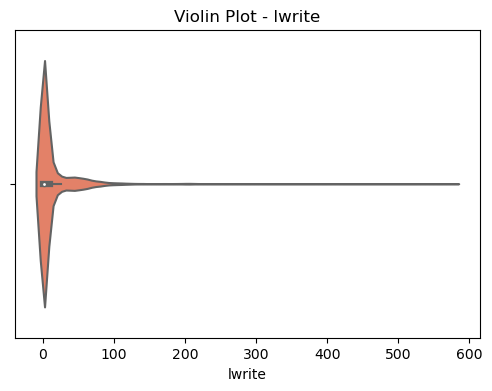

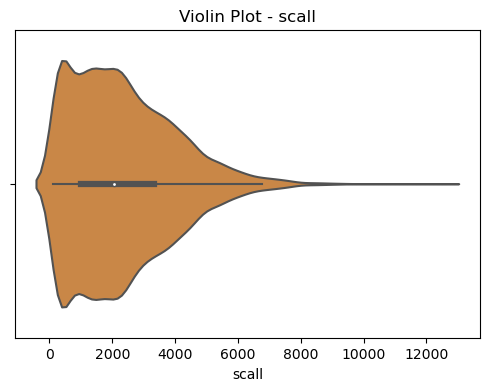

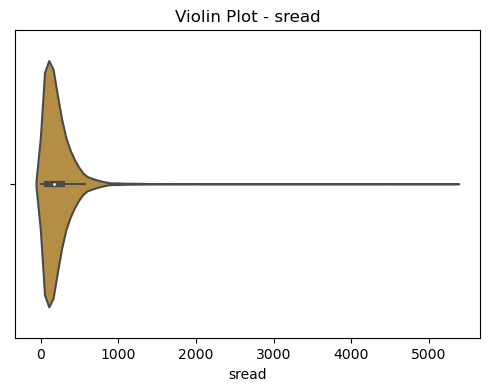

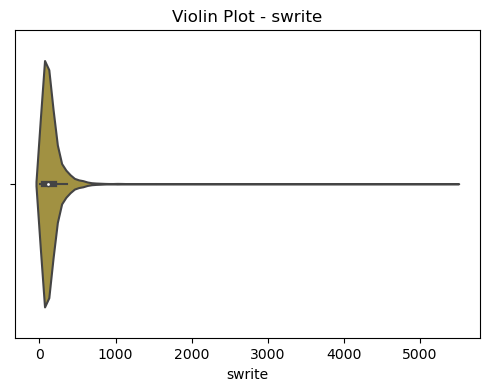

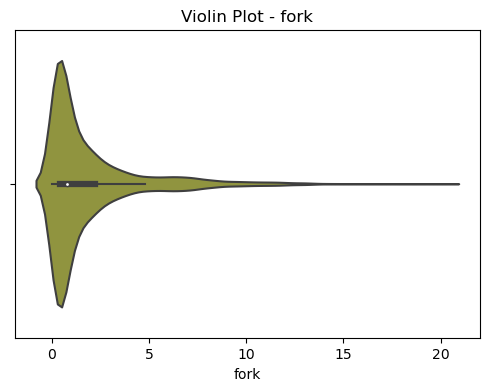

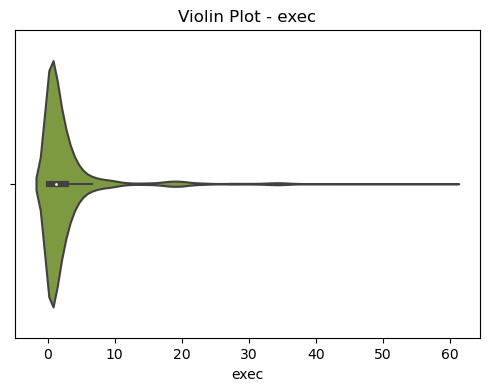

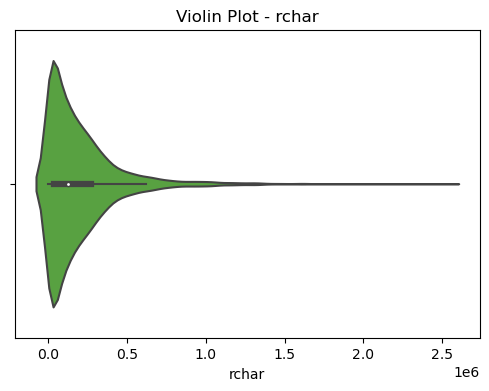

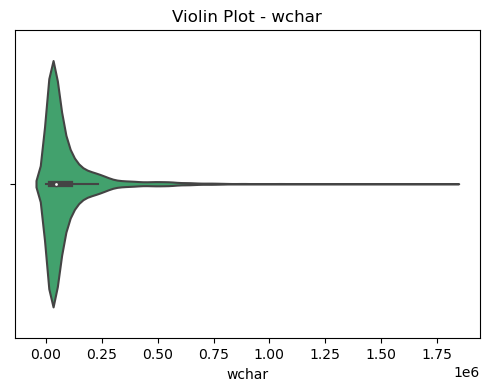

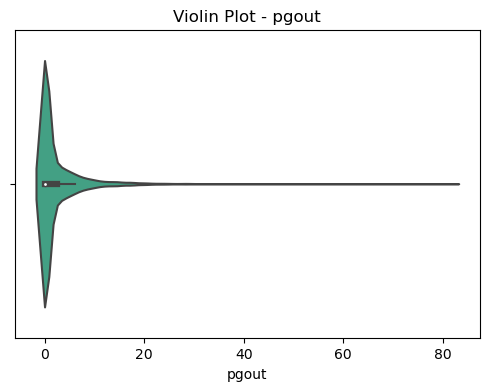

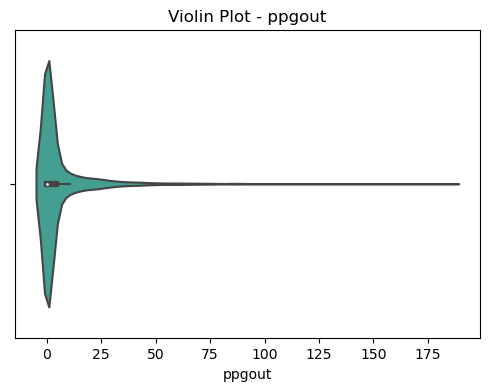

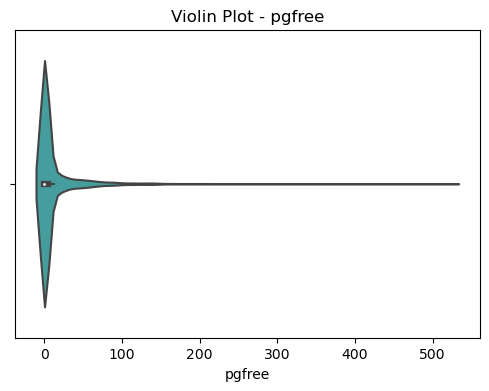

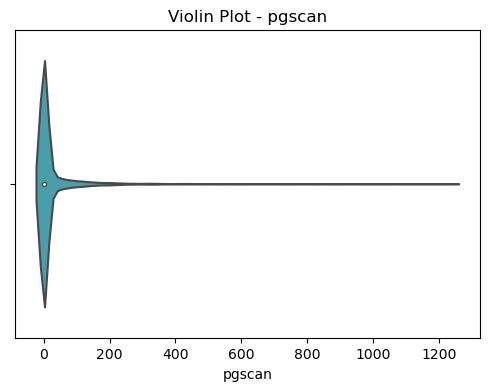

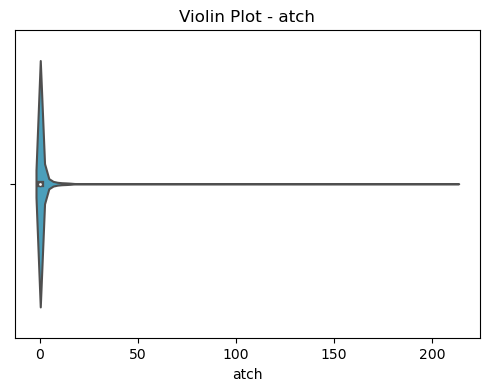

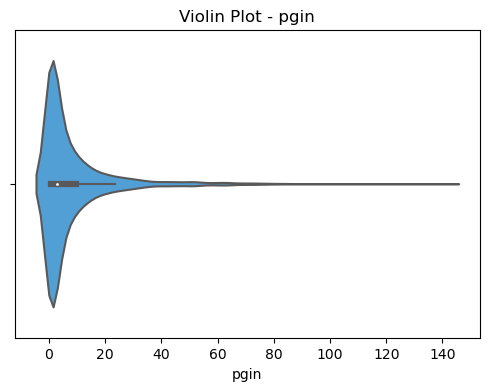

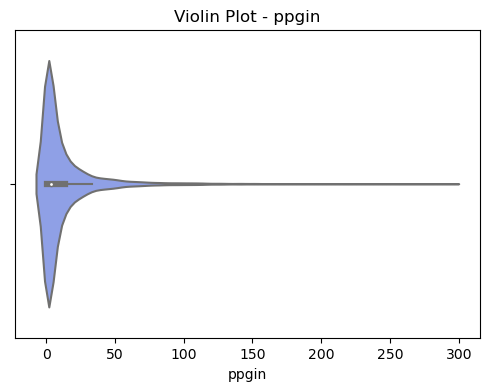

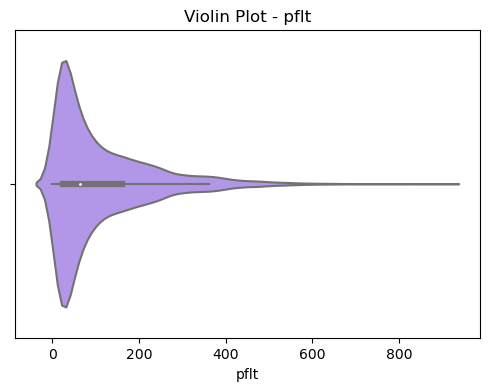

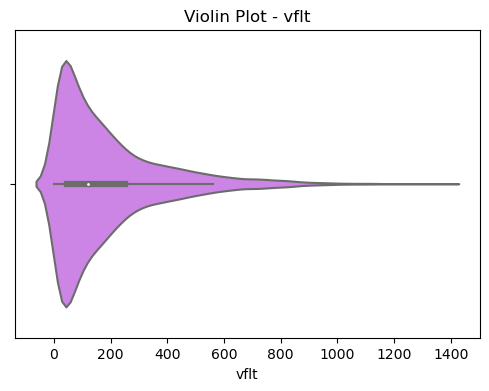

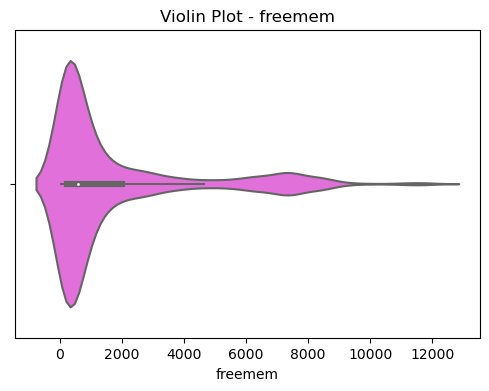

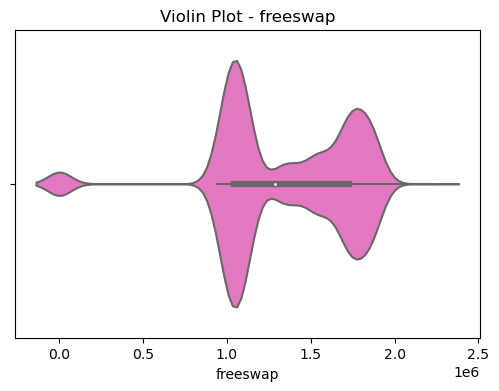

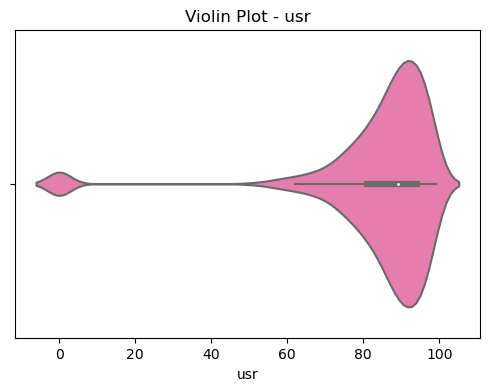

In [6]:
colors = sns.color_palette("husl", n_colors=21)
for i, column in enumerate(df_uni.columns):
    plt.figure(figsize=(6, 4))
    sns.violinplot(x=df_uni[column], color=colors[i])
    plt.title(f'Violin Plot - {column}')
    plt.show()

<Axes: xlabel='runqsz', ylabel='count'>

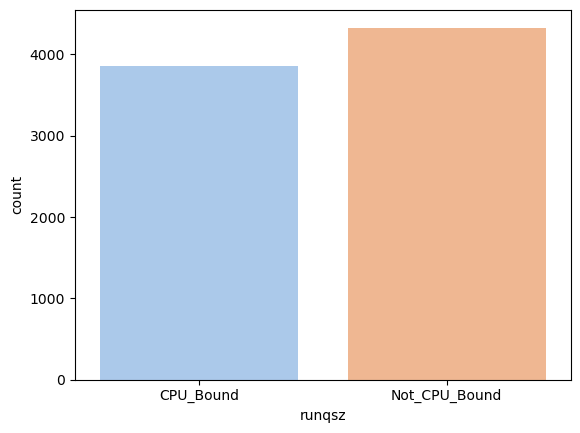

In [7]:
sns.countplot(x='runqsz', data=df, palette="pastel")

The above plot for the variables "runqsz" indicate there is a balance between the the two values (CPU_Bond and Not_CPU_Bound). Further indicating absence of Imbalanced data for this particular variable

## Multivariate Analysis

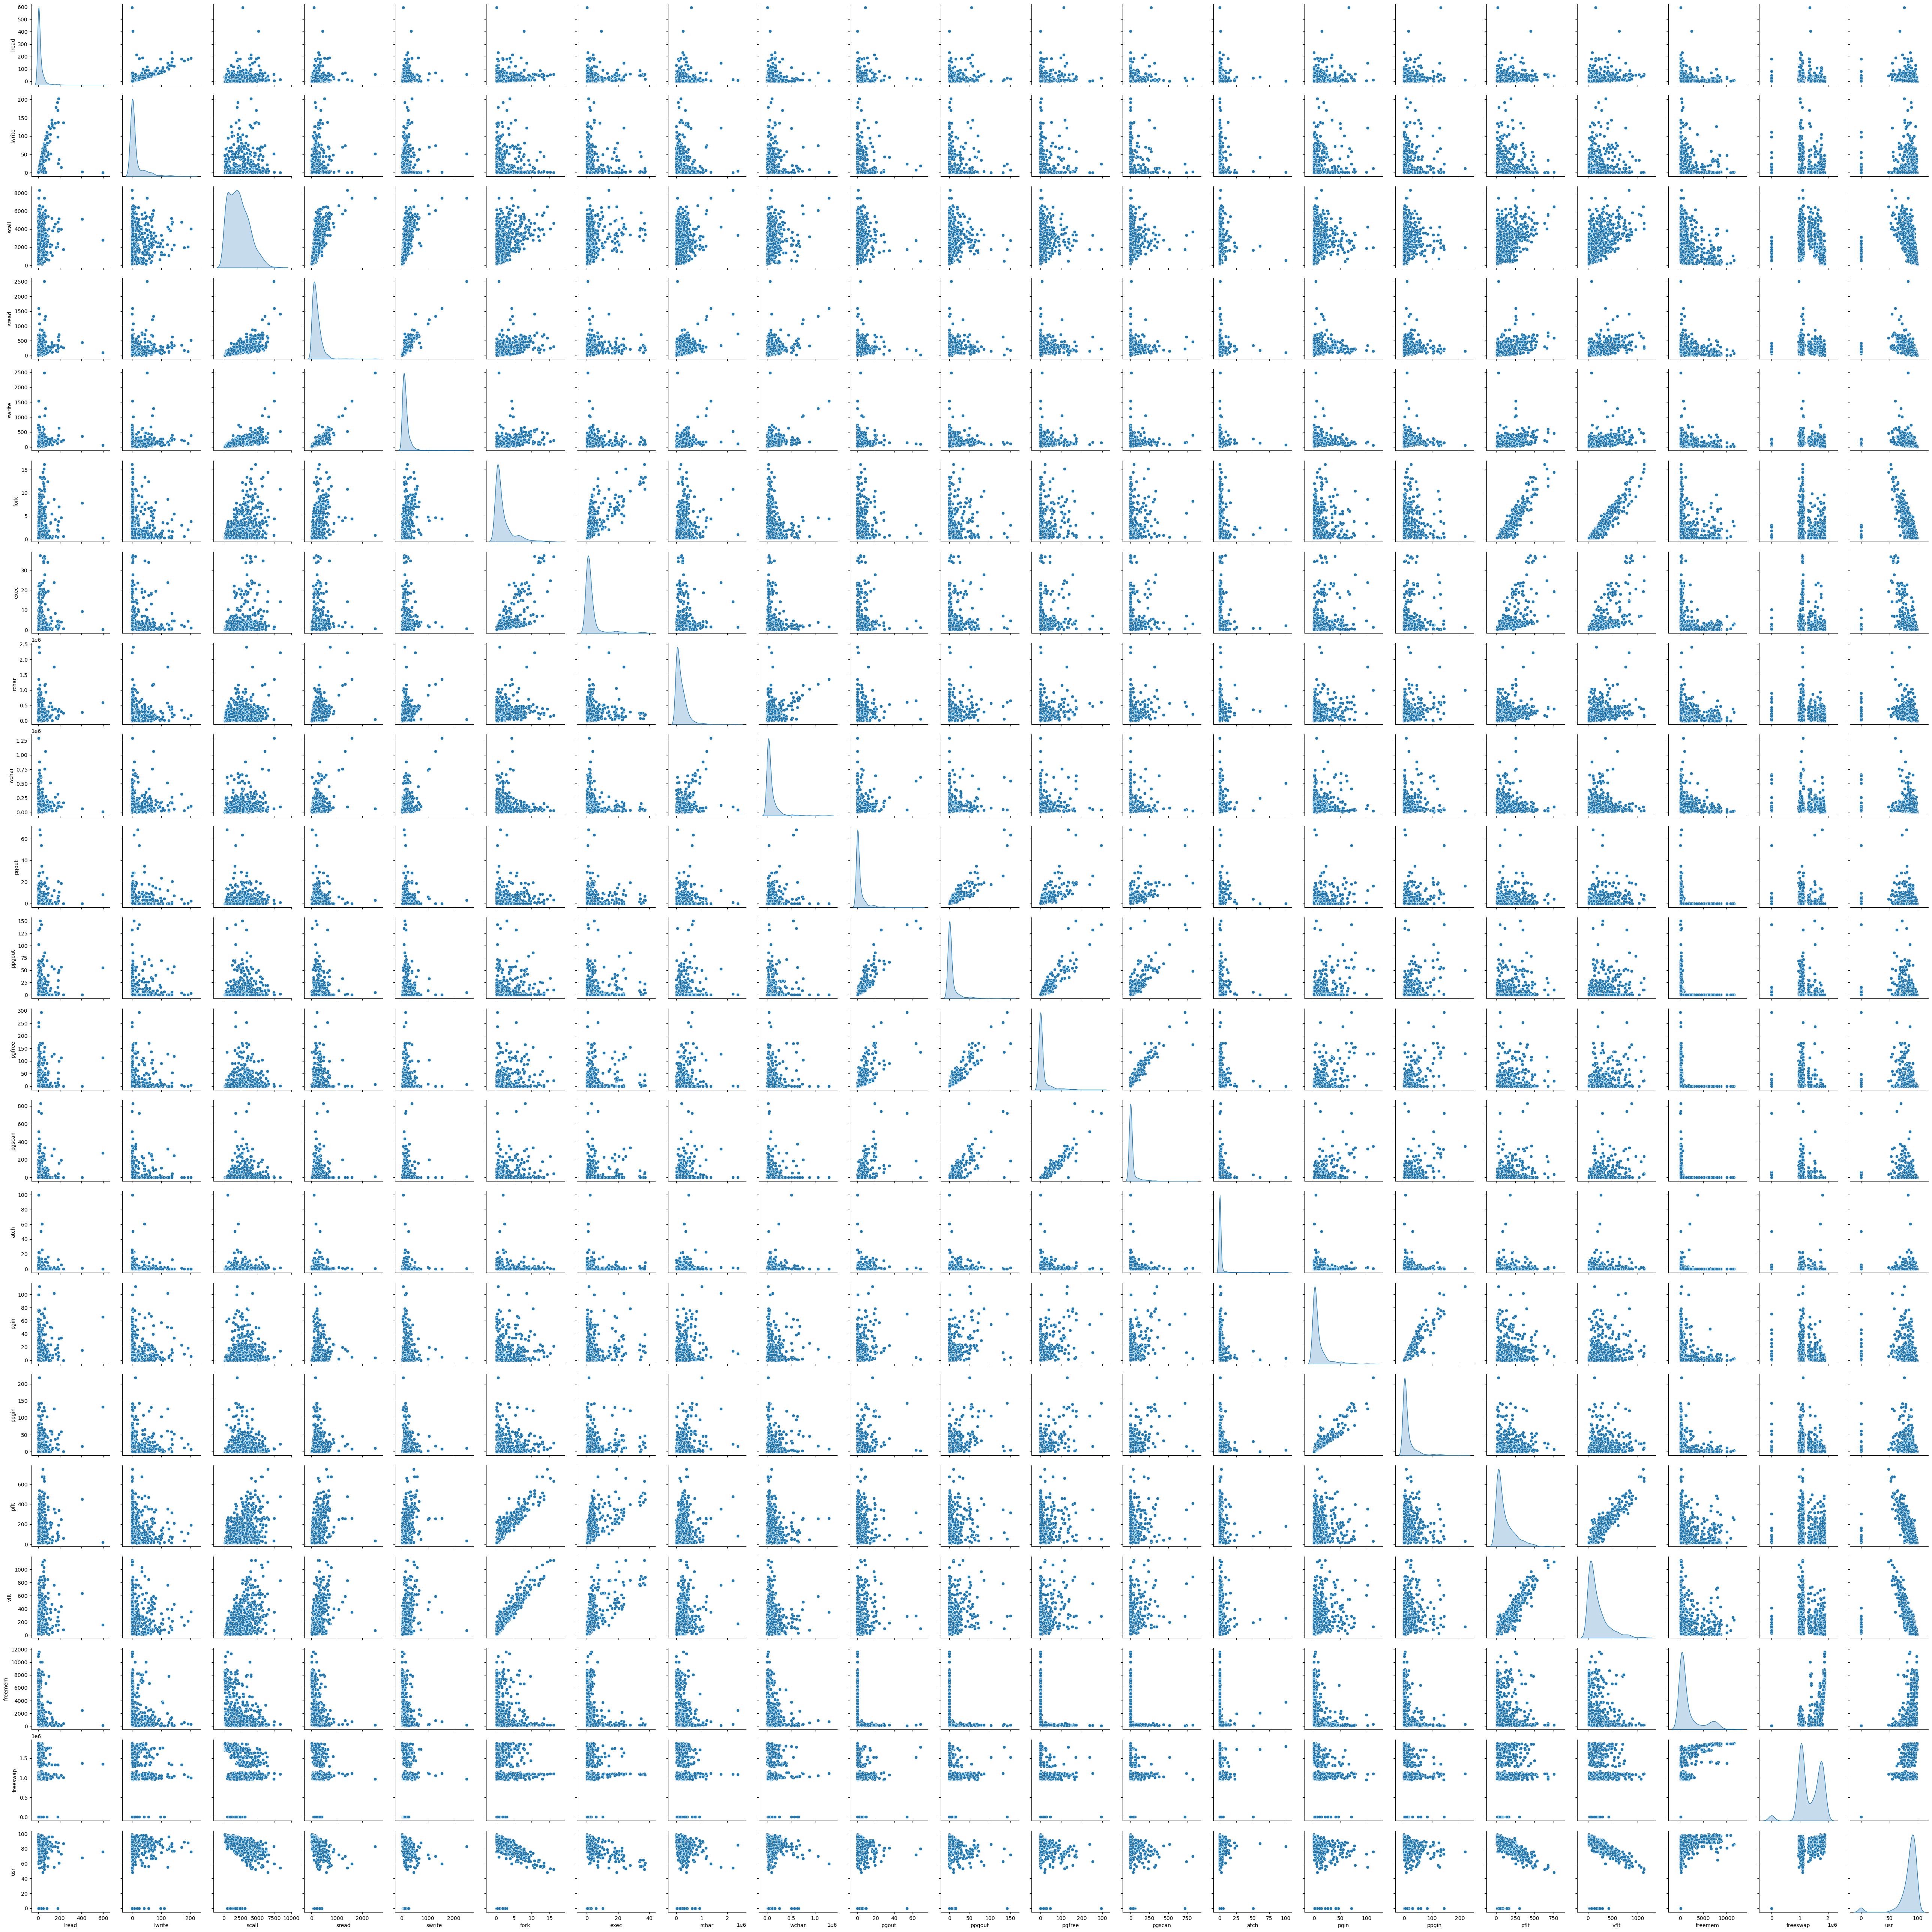

In [8]:
subset_df = df_uni.sample(frac=0.1)
sns.pairplot(subset_df, diag_kind="kde")
plt.show()

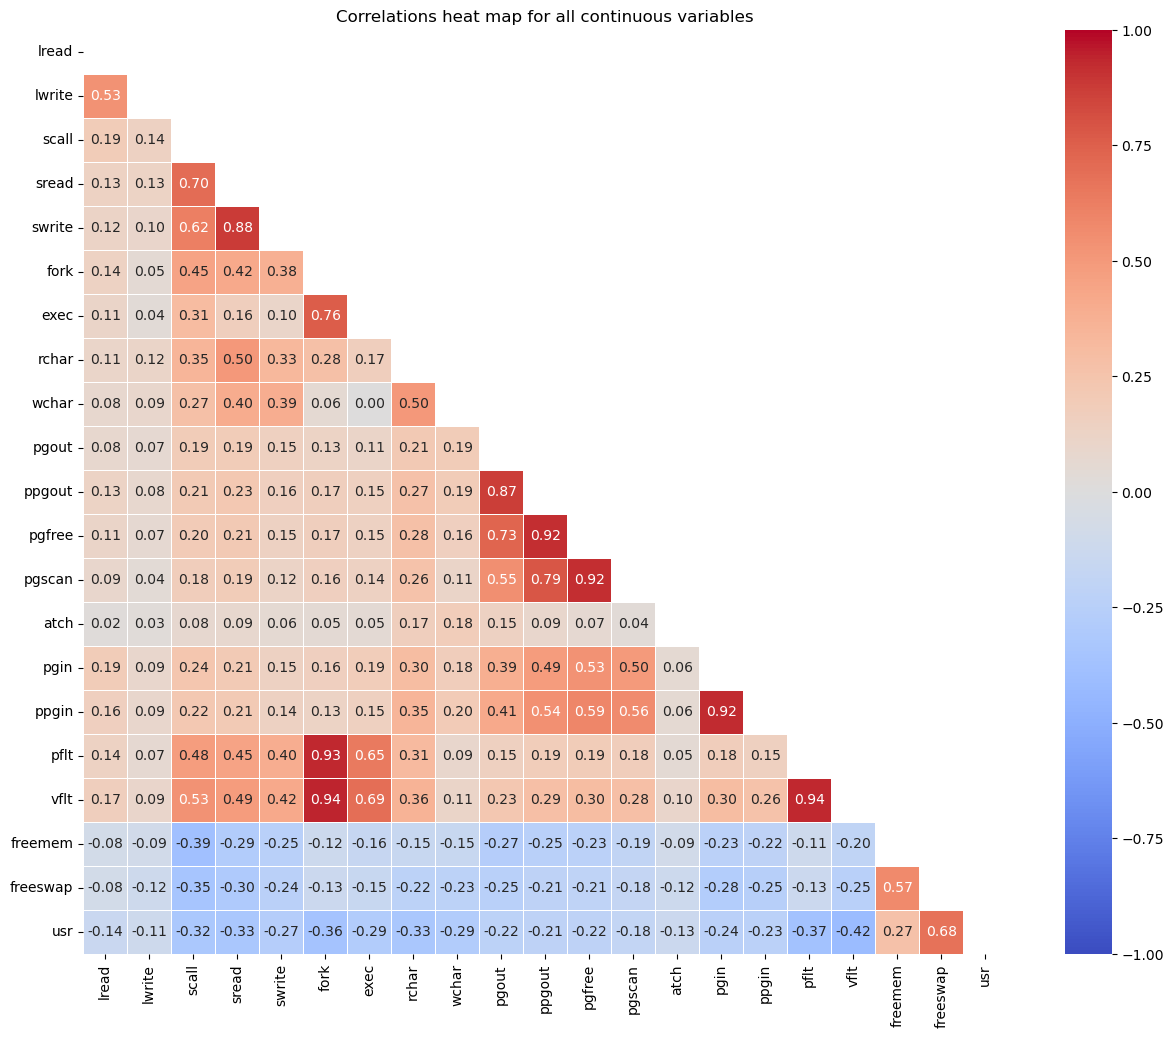

In [9]:
correlation_matrix = df_uni.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, square=True, mask=mask, annot_kws={"size": 10}, vmin=-1, vmax=1)
plt.title("Correlations heat map for all continuous variables")

# Show the plot
plt.show()

<Axes: xlabel='runqsz', ylabel='usr'>

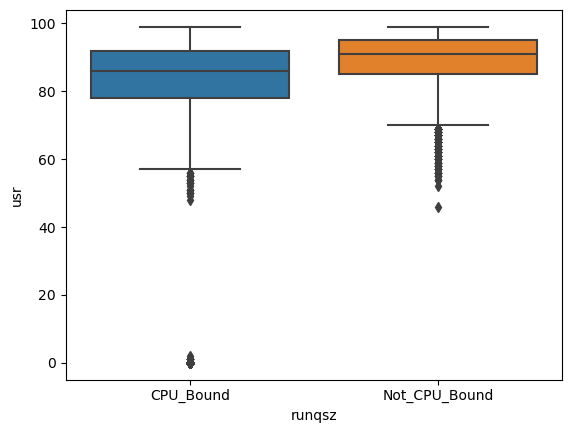

In [10]:
# Target column analysis
sns.boxplot(x='runqsz', y='usr', data=df)

## Zero Inflated Dataset

In [11]:
zero_counts = (df == 0).sum()

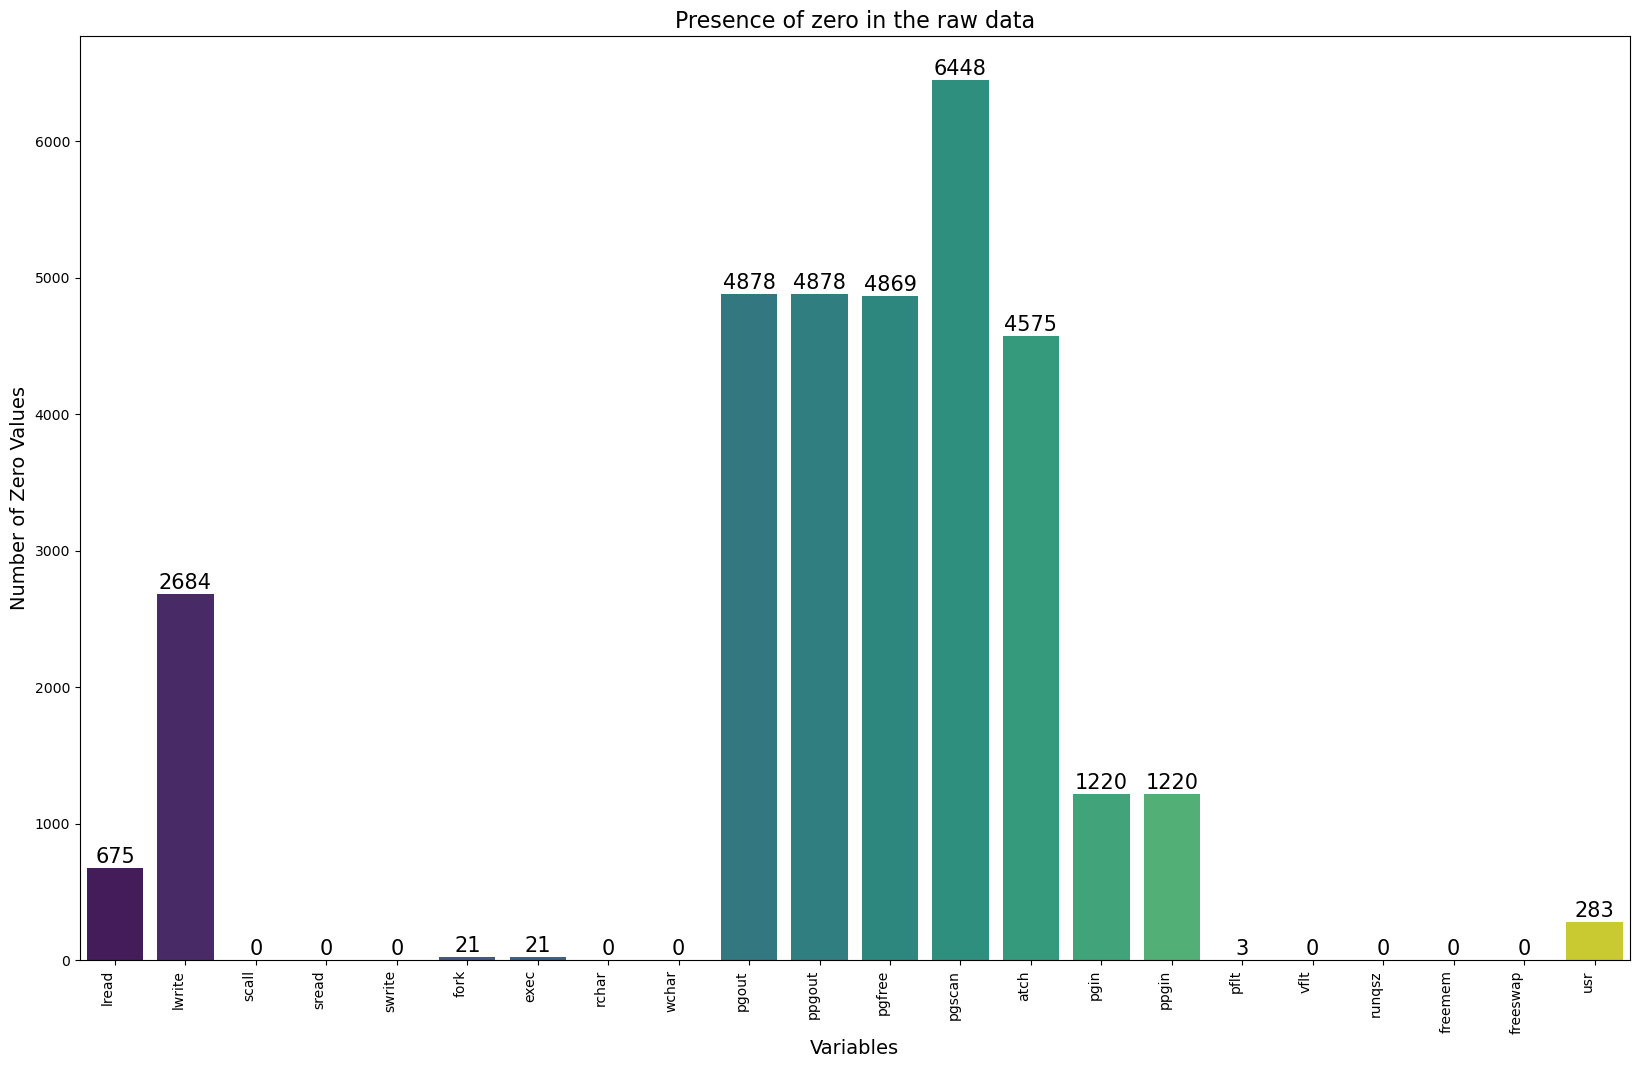

In [12]:
plt.figure(figsize=(20, 12))
plots=sns.barplot(x=zero_counts.index, y=zero_counts.values, palette='viridis')

for bar in plots.patches:
   

    plots.annotate(f'{int(bar.get_height())}', 
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Number of Zero Values', fontsize=14)
plt.title("Presence of zero in the raw data", fontsize=16)
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.show()

We need to keep in mind the data is hugely affected by the presence of large number of zeroes, zero inflated datasets ruin the regression model. Also it is evidently visible that the data is skewed as seen in the univariate analysis. Multiple approaches for building the model could possibly provide a solution since a single ad-hoc approach could not be the right solution.

In [13]:
round(6448/len(df["pgscan"]),2)*100

79.0

# Since the variable "pgscan" consists of 79% of zero's it should cause no harm if it is dropped from the dataset.

In [14]:
df = df.drop("pgscan", axis=1)

In [15]:
df.isna().sum()

lread         0
lwrite        0
scall         0
sread         0
swrite        0
fork          0
exec          0
rchar       104
wchar        15
pgout         0
ppgout        0
pgfree        0
atch          0
pgin          0
ppgin         0
pflt          0
vflt          0
runqsz        0
freemem       0
freeswap      0
usr           0
dtype: int64

### The range (0 to 2) looks odd in the "usr" variable we will analyze that

In [16]:
zero_analytics = df.loc[df['usr'] <= 2]

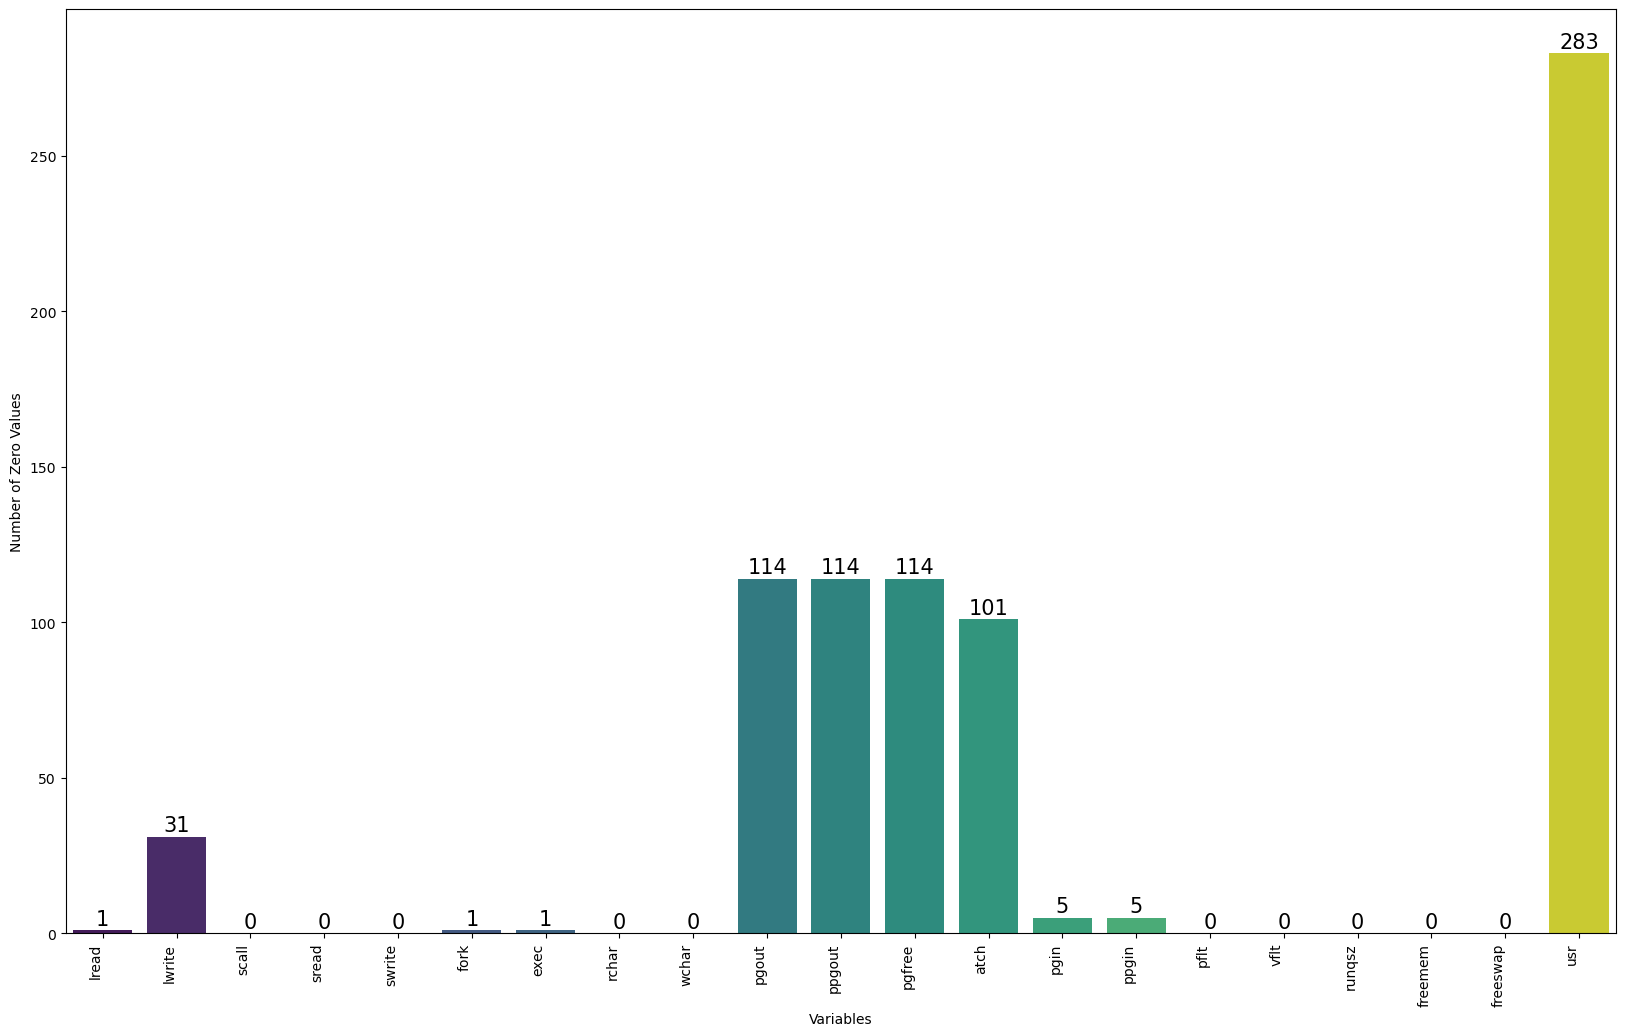

In [17]:
zero_counts = (zero_analytics == 0).sum()
plt.figure(figsize=(20, 12))
plots=sns.barplot(x=zero_counts.index, y=zero_counts.values, palette='viridis')

for bar in plots.patches:
   

    plots.annotate(f'{int(bar.get_height())}', 
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel('Variables')
plt.ylabel('Number of Zero Values')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.show()

### "usr" variable which is the dependent represents the the percentage of time CPUs operate in user mode. If the values are zero in this variable it suggests that either the CPU is is not operating or might be miscalculated. SInce this could affect our model building and also the quantity is small we will drop the records and associated with it wherever there are zero, one and two sice even they are very less in count and sound inappropriate from the problem statement.

In [18]:
new_df = df.loc[df['usr'] > 2].reset_index(drop=True)

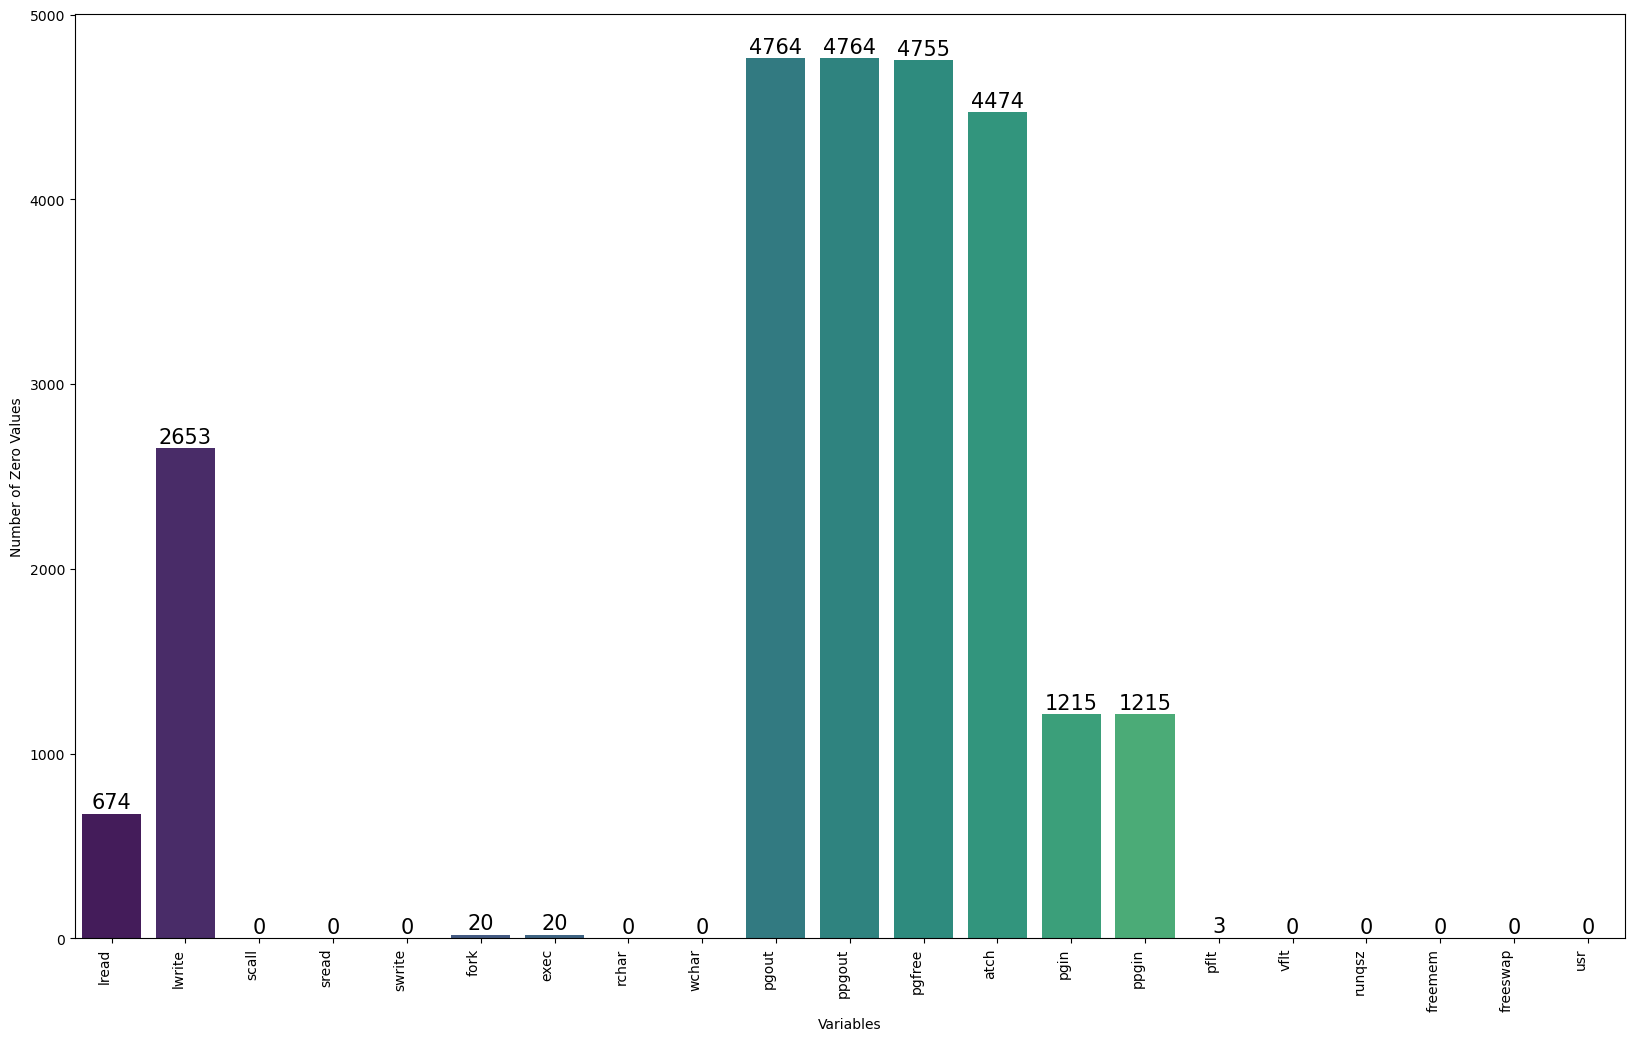

In [19]:
zero_counts = (new_df == 0).sum()
plt.figure(figsize=(20, 12))
plots=sns.barplot(x=zero_counts.index, y=zero_counts.values, palette='viridis')

for bar in plots.patches:
   

    plots.annotate(f'{int(bar.get_height())}', 
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel('Variables')
plt.ylabel('Number of Zero Values')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.show()

## We will now find the asssociation of zero with the target variable, let us see if they represent something by checking the distribution of target when the values are zeroes and when they are not zeroes

In [20]:
zero = new_df.loc[new_df['pgout'] == 0].reset_index(drop=True)
zero

lread  lwrite  scall  sread  swrite  fork  exec     rchar     wchar  \
0         1       0   2147     79      68  0.20  0.20   40671.0   53995.0   
1         0       0    170     18      21  0.20  0.20     448.0    8385.0   
2        15       3   2162    159     119  2.00  2.40       NaN   31950.0   
3         0       0    160     12      16  0.20  0.20       NaN    8670.0   
4         5       1    330     39      38  0.40  0.40       NaN   12185.0   
...     ...     ...    ...    ...     ...   ...   ...       ...       ...   
4759     21      18    718     43      47  3.39  3.39   92375.0   78566.0   
4760      4       1   1062    141     126  2.80  1.20   74472.0    6098.0   
4761      9       1   1799    127      87  1.80  4.19  104229.0   37594.0   
4762      4       3   1509    501     139  0.60  1.00  312242.0  255308.0   
4763      2       0    985     55      46  1.60  4.80  111111.0   22256.0   

      pgout  ...  pgfree  atch  pgin  ppgin    pflt    vflt         runqsz  \
0       0.0  ...     0.0   0.0  1.60   2.60   16.00   26.40      CPU_Bound   
1       0.0  ...     0.0   0.0  0.00   0.00   15.63   16.83  Not_CPU_Bound   
2       0.0  ...     0.0   1.2  6.00   9.40  150.20  220.20  Not_CPU_Bound   
3       0.0  ...     0.0   0.0  0.20   0.20   15.60   16.80  Not_CPU_Bound   
4       0.0  ...     0.0   0.0  1.00   1.20   37.80   47.60  Not_CPU_Bound   
...     ...  ...     ...   ...   ...    ...     ...     ...            ...   
4759    0.0  ...     0.0   0.0  3.79   6.99  257.88  389.22  Not_CPU_Bound   
4760    0.0  ...     0.0   0.0  0.00   0.00  161.80  211.20  Not_CPU_Bound   
4761    0.0  ...     0.0   0.0  0.60   0.80  120.16  164.87      CPU_Bound   
4762    0.0  ...     0.0   0.0  3.20   3.20   52.60  119.60      CPU_Bound   
4763    0.0  ...     0.0   0.2  3.40   6.20   91.80  110.00      CPU_Bound   

     freemem  freeswap  usr  
0       4670   1730946   95  
1       7278   1869002   97  
2        702   1021237   87  
3       7248   1863704   98  
4        633   1760253   90  
...      ...       ...  ...  
4759    6210   1848837   85  
4760    7349   1864162   93  
4761     808   1529517   92  
4762    1051   1600333   92  
4763     659   1756514   94  

[4764 rows x 21 columns]

### It was noted that the variables "pgout" and "ppgout" has the highest and same number of zeros after dropping the variable "pgscan"(accounting to 75% of zeros). Whenever the pgout variable had zeros in it, the other columns with zeros also accounted to 90% association with zero.

In [21]:
non_zero = new_df.loc[new_df['pgout'] > 0].reset_index(drop=True)
non_zero

lread  lwrite  scall  sread  swrite  fork  exec     rchar     wchar  \
0         1       0   5744    168     190   0.2  0.20       NaN  189975.0   
1         6       1   2348    144     103   2.4  0.80       NaN   10148.0   
2         0       0    596     45     196   0.2  0.20       NaN  223361.0   
3         3       0   1131     74      44   1.2  1.80       NaN    8905.0   
4        11       4   4406    177     151   5.2  5.20       NaN    6300.0   
...     ...     ...    ...    ...     ...   ...   ...       ...       ...   
3129      0       0    300     56      46   0.2  0.20    1995.0   18052.0   
3130     16      12   3009    360     244   1.6  5.81  405250.0   85282.0   
3131      4       0   1596    170     146   2.4  1.80   89489.0   41764.0   
3132     16       5   3116    289     190   0.6  0.60  325948.0   52640.0   
3133     32      45   5180    254     179   1.2  1.20   62571.0   29505.0   

      pgout  ...  pgfree  atch   pgin  ppgin    pflt    vflt         runqsz  \
0      6.00  ...    8.00   4.4   0.60   0.60   27.40   28.60  Not_CPU_Bound   
1      0.20  ...    0.20   0.2   1.00   1.00  121.80  166.80      CPU_Bound   
2      1.80  ...    1.80   0.0   0.40   0.40   15.60   19.60  Not_CPU_Bound   
3      0.80  ...   12.80   0.0   4.20   7.40  108.60  142.40      CPU_Bound   
4      2.40  ...    2.60   4.6  11.40  11.80  202.00  418.40      CPU_Bound   
...     ...  ...     ...   ...    ...    ...     ...     ...            ...   
3129   0.80  ...    0.80   0.0   0.00   0.00   21.00   18.00  Not_CPU_Bound   
3130   8.02  ...   43.69   0.6  35.87  47.90  139.28  270.74      CPU_Bound   
3131   3.80  ...    4.80   0.8   3.80   4.40  122.40  212.60  Not_CPU_Bound   
3132   0.40  ...    0.60   0.4  28.40  45.20   60.20  219.80  Not_CPU_Bound   
3133   1.40  ...   13.03   0.4  23.05  24.25   93.19  202.81      CPU_Bound   

     freemem  freeswap  usr  
0        312   1013458   89  
1        298   1709362   92  
2        165   1749568   96  
3        133   1703250   94  
4        233   1447301   85  
...      ...       ...  ...  
3129     272   1754832   97  
3130     387    986647   80  
3131     263   1055742   90  
3132     400    969106   87  
3133     141   1022458   83  

[3134 rows x 21 columns]

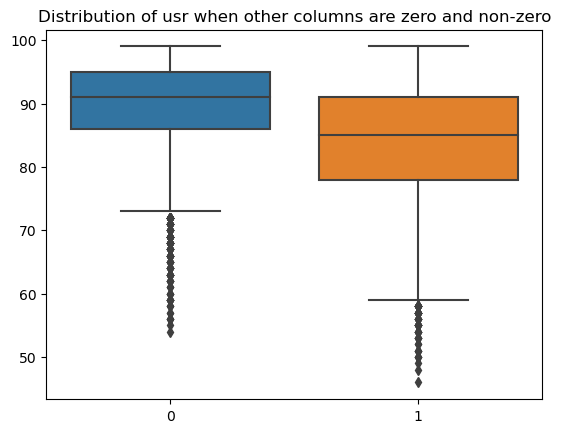

In [22]:
sns.boxplot(data = [zero['usr'], non_zero['usr']])
plt.title("Distribution of usr when other columns are zero and non-zero")
plt.show()

## Though there is a slight change in the mean of the ditribution, when comparing it seems there is not much of deviation. Inspite of this, the zero values could imply legit values or it could also impy  wrong values or missing values

# Approach 1

# Data Pre-processing

In this approach we will drop the variables that have more than 50% of zeros in their column, and convert the other zeroes in to NaN and impute it using knn Imputer

In [23]:
new_df

lread  lwrite  scall  sread  swrite  fork  exec     rchar    wchar  \
0         1       0   2147     79      68   0.2  0.20   40671.0  53995.0   
1         0       0    170     18      21   0.2  0.20     448.0   8385.0   
2        15       3   2162    159     119   2.0  2.40       NaN  31950.0   
3         0       0    160     12      16   0.2  0.20       NaN   8670.0   
4         5       1    330     39      38   0.4  0.40       NaN  12185.0   
...     ...     ...    ...    ...     ...   ...   ...       ...      ...   
7893     16      12   3009    360     244   1.6  5.81  405250.0  85282.0   
7894      4       0   1596    170     146   2.4  1.80   89489.0  41764.0   
7895     16       5   3116    289     190   0.6  0.60  325948.0  52640.0   
7896     32      45   5180    254     179   1.2  1.20   62571.0  29505.0   
7897      2       0    985     55      46   1.6  4.80  111111.0  22256.0   

      pgout  ...  pgfree  atch   pgin  ppgin    pflt    vflt         runqsz  \
0      0.00  ...    0.00   0.0   1.60   2.60   16.00   26.40      CPU_Bound   
1      0.00  ...    0.00   0.0   0.00   0.00   15.63   16.83  Not_CPU_Bound   
2      0.00  ...    0.00   1.2   6.00   9.40  150.20  220.20  Not_CPU_Bound   
3      0.00  ...    0.00   0.0   0.20   0.20   15.60   16.80  Not_CPU_Bound   
4      0.00  ...    0.00   0.0   1.00   1.20   37.80   47.60  Not_CPU_Bound   
...     ...  ...     ...   ...    ...    ...     ...     ...            ...   
7893   8.02  ...   43.69   0.6  35.87  47.90  139.28  270.74      CPU_Bound   
7894   3.80  ...    4.80   0.8   3.80   4.40  122.40  212.60  Not_CPU_Bound   
7895   0.40  ...    0.60   0.4  28.40  45.20   60.20  219.80  Not_CPU_Bound   
7896   1.40  ...   13.03   0.4  23.05  24.25   93.19  202.81      CPU_Bound   
7897   0.00  ...    0.00   0.2   3.40   6.20   91.80  110.00      CPU_Bound   

     freemem  freeswap  usr  
0       4670   1730946   95  
1       7278   1869002   97  
2        702   1021237   87  
3       7248   1863704   98  
4        633   1760253   90  
...      ...       ...  ...  
7893     387    986647   80  
7894     263   1055742   90  
7895     400    969106   87  
7896     141   1022458   83  
7897     659   1756514   94  

[7898 rows x 21 columns]

In [24]:
zero_percentage = round((new_df == 0).mean() * 100, 2)
print(zero_percentage)

lread        8.53
lwrite      33.59
scall        0.00
sread        0.00
swrite       0.00
fork         0.25
exec         0.25
rchar        0.00
wchar        0.00
pgout       60.32
ppgout      60.32
pgfree      60.21
atch        56.65
pgin        15.38
ppgin       15.38
pflt         0.04
vflt         0.00
runqsz       0.00
freemem      0.00
freeswap     0.00
usr          0.00
dtype: float64


Now the variable having zero above 50% will be dropped from the data

In [25]:
# Set the threshold for dropping columns
threshold = 50

# Identify columns with zero percentage above the threshold
columns_to_drop = zero_percentage[zero_percentage > threshold].index

# Drop columns
df1 = new_df.drop(columns=columns_to_drop)

Convert 0 to NaN for further imputing them.

In [26]:
df1.replace(0, np.nan, inplace=True)

Missing Value Treatment

In [27]:
df1.isna().sum()

lread        674
lwrite      2653
scall          0
sread          0
swrite         0
fork          20
exec          20
rchar         98
wchar         15
pgin        1215
ppgin       1215
pflt           3
vflt           0
runqsz         0
freemem        0
freeswap       0
usr            0
dtype: int64

As there are nan in the data the average value could be affected by it. Hence, imputing the Nan/Missing values can be done by choosing the Median or by knn imputer.

## knn imputer

In [28]:
# Separate features and target
X = df1.drop(['usr', 'runqsz'], axis=1)
y = df1[['usr', 'runqsz']]

In [29]:
knn_imputer = KNNImputer()
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

# Combining imputed features with the target column
df_imputed = pd.concat([X_imputed, y], axis=1)

In [30]:
#for column in df.columns:
 #   if df[column].dtype != 'object':
  #      median = df[column].median()
   #     df[column] = df[column].fillna(median)    
        
#df.isnull().sum()        

Data Encoding: Converting the Object into categorical and further numerical categories

In [31]:
df_imputed['runqsz'].unique()

array(['CPU_Bound', 'Not_CPU_Bound'], dtype=object)

In [32]:
df_imputed['runqsz'].value_counts()

Not_CPU_Bound    4331
CPU_Bound        3567
Name: runqsz, dtype: int64

The categorical variable "runqsz" consists of Balanced value among the category. Hence, the presence of imbalance dataset for this particular variable is ruled out.

In [33]:
df_imputed['runqsz'] = pd.Categorical(df_imputed['runqsz'])

In [34]:
data = pd.get_dummies(df_imputed, columns=["runqsz"], drop_first=True)
data

lread  lwrite   scall  sread  swrite  fork  exec     rchar    wchar  \
0       1.0     8.6  2147.0   79.0    68.0   0.2  0.20   40671.0  53995.0   
1       4.8    14.2   170.0   18.0    21.0   0.2  0.20     448.0   8385.0   
2      15.0     3.0  2162.0  159.0   119.0   2.0  2.40  149648.0  31950.0   
3       2.8    34.0   160.0   12.0    16.0   0.2  0.20  187964.8   8670.0   
4       5.0     1.0   330.0   39.0    38.0   0.4  0.40   28117.0  12185.0   
...     ...     ...     ...    ...     ...   ...   ...       ...      ...   
7893   16.0    12.0  3009.0  360.0   244.0   1.6  5.81  405250.0  85282.0   
7894    4.0     7.0  1596.0  170.0   146.0   2.4  1.80   89489.0  41764.0   
7895   16.0     5.0  3116.0  289.0   190.0   0.6  0.60  325948.0  52640.0   
7896   32.0    45.0  5180.0  254.0   179.0   1.2  1.20   62571.0  29505.0   
7897    2.0    27.2   985.0   55.0    46.0   1.6  4.80  111111.0  22256.0   

       pgin  ppgin    pflt    vflt  freemem   freeswap  usr  \
0      1.60   2.60   16.00   26.40   4670.0  1730946.0   95   
1      0.20   0.24   15.63   16.83   7278.0  1869002.0   97   
2      6.00   9.40  150.20  220.20    702.0  1021237.0   87   
3      0.20   0.20   15.60   16.80   7248.0  1863704.0   98   
4      1.00   1.20   37.80   47.60    633.0  1760253.0   90   
...     ...    ...     ...     ...      ...        ...  ...   
7893  35.87  47.90  139.28  270.74    387.0   986647.0   80   
7894   3.80   4.40  122.40  212.60    263.0  1055742.0   90   
7895  28.40  45.20   60.20  219.80    400.0   969106.0   87   
7896  23.05  24.25   93.19  202.81    141.0  1022458.0   83   
7897   3.40   6.20   91.80  110.00    659.0  1756514.0   94   

      runqsz_Not_CPU_Bound  
0                        0  
1                        1  
2                        1  
3                        1  
4                        1  
...                    ...  
7893                     0  
7894                     1  
7895                     1  
7896                     0  
7897                     0  

[7898 rows x 17 columns]

We have now converted the 'runqsz' column to categorical and further assigned the dummy variables and have kept only one value count(Not CPU Bound) which will be 1 and the 0's are the CPU Bound.

### Statistical Summary

In [35]:
data.describe().T

count          mean            std        min  \
lread                 7898.0  2.041765e+01      54.029048       1.00   
lwrite                7898.0  1.938362e+01      29.869393       1.00   
scall                 7898.0  2.311646e+03    1647.288204     109.00   
sread                 7898.0  2.085104e+02     199.659158       6.00   
swrite                7898.0  1.493359e+02     161.945630       7.00   
fork                  7898.0  1.895272e+00       2.487616       0.19   
exec                  7898.0  2.814882e+00       5.264741       0.19   
rchar                 7898.0  1.911233e+05  231432.044978     278.00   
wchar                 7898.0  9.095163e+04  128849.350224    1498.00   
pgin                  7898.0  8.568614e+00      13.649777       0.19   
ppgin                 7898.0  1.276073e+01      21.825784       0.20   
pflt                  7898.0  1.101396e+02     114.660397       0.80   
vflt                  7898.0  1.849226e+02     191.720331       0.20   
freemem               7898.0  1.825884e+03    2506.311677      85.00   
freeswap              7898.0  1.377564e+06  341494.218881  942600.00   
usr                   7898.0  8.709306e+01       8.901303      46.00   
runqsz_Not_CPU_Bound  7898.0  5.483667e-01       0.497687       0.00   

                             25%          50%         75%         max  
lread                       3.00        8.000       20.00     1845.00  
lwrite                      2.00       10.000       24.00      575.00  
scall                     976.25     2060.500     3349.75    12493.00  
sread                      84.00      163.000      276.00     5318.00  
swrite                     62.00      116.000      185.00     5456.00  
fork                        0.40        0.800        2.40       20.12  
exec                        0.20        1.200        2.80       59.56  
rchar                   33228.50   121854.000   261884.00  2526649.00  
wchar                   22599.75    45752.000   103993.75  1523413.00  
pgin                        1.00        3.200        9.82      141.20  
ppgin                       1.20        4.698       14.37      292.61  
pflt                       24.40       64.200      160.20      899.80  
vflt                       44.71      119.400      251.60     1365.00  
freemem                   253.00      619.500     2104.75    12027.00  
freeswap              1054175.00  1323393.500  1735536.75  2243187.00  
usr                        83.00       89.000       94.00       99.00  
runqsz_Not_CPU_Bound        0.00        1.000        1.00        1.00

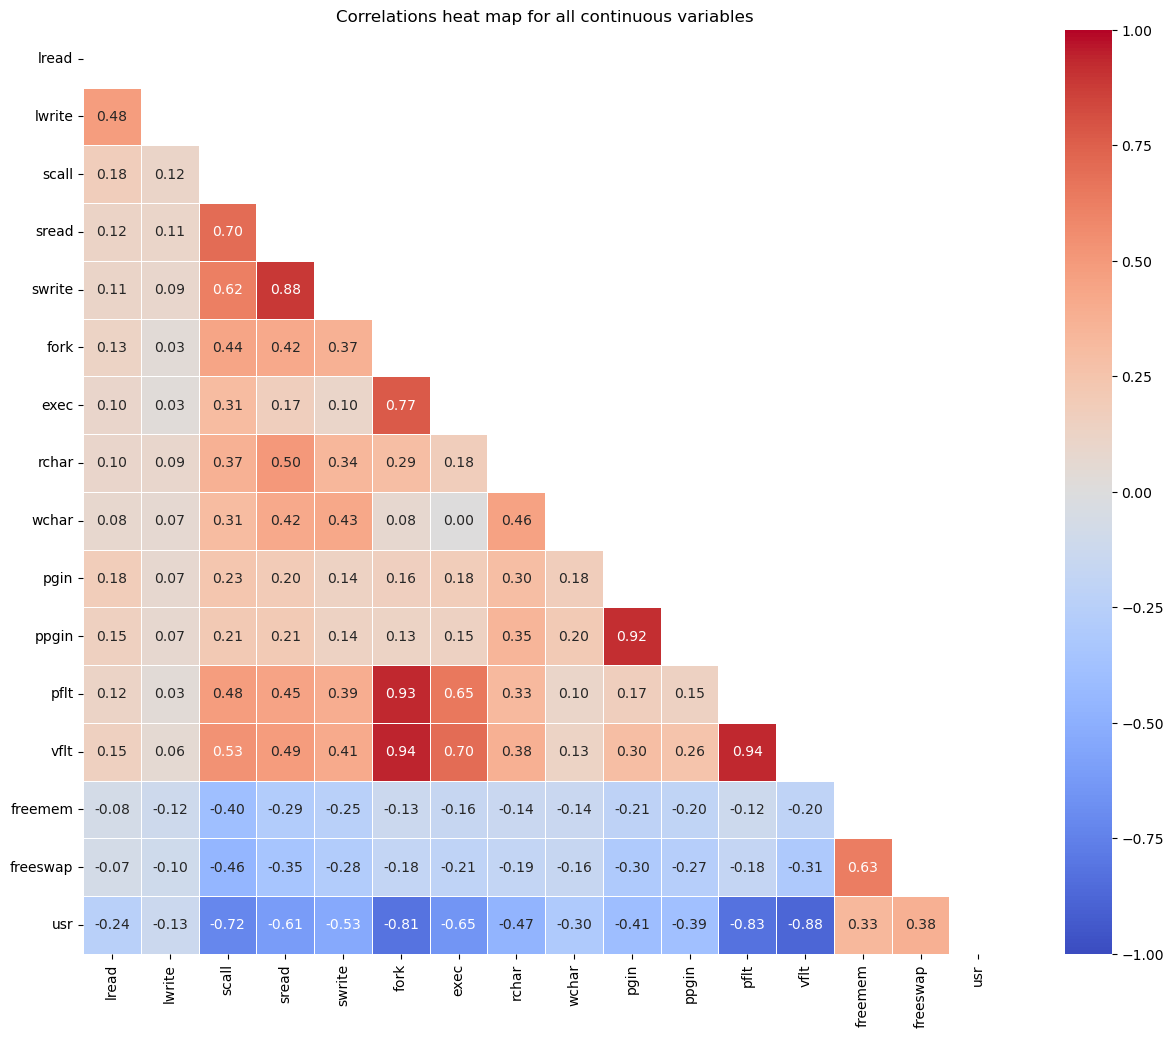

In [36]:
corr_df = data.drop('runqsz_Not_CPU_Bound', axis=1)
correlation_matrix = corr_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, square=True, mask=mask, annot_kws={"size": 10}, vmin=-1, vmax=1)
plt.title("Correlations heat map for all continuous variables")

# Show the plot
plt.show()

# Model building

## Split the data

In [37]:
#  'vflt', 'fork', 'ppgin'
X = data.drop(['usr'], axis=1)
y = data['usr']

In [38]:
# let's add the intercept to data
X = sm.add_constant(X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [40]:
olsmod = sm.OLS(y_train, X_train)
ols = olsmod.fit()

In [41]:
print(ols.summary())    

                            OLS Regression Results                            
Dep. Variable:                    usr   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     3552.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:25:07   Log-Likelihood:                -13216.
No. Observations:                5528   AIC:                         2.647e+04
Df Residuals:                    5511   BIC:                         2.658e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   99.1985 

### SInce there is a presence of strong multicollinearity we would look to solve it using VIF

In [42]:
vif_series1 = pd.Series(
    [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
    index=X_train.columns,
)
print("VIF values: \n\n{}\n".format(vif_series1))

VIF values: 

const                   52.498058
lread                    1.288672
lwrite                   1.251200
scall                    2.710604
sread                    5.684514
swrite                   4.936152
fork                    17.929379
exec                     3.304752
rchar                    1.864175
wchar                    1.574556
pgin                     6.657552
ppgin                    6.477112
pflt                    11.684069
vflt                    18.172451
freemem                  1.800041
freeswap                 2.241007
runqsz_Not_CPU_Bound     1.213127
dtype: float64



Dropping multicollinear columns one by one

In [43]:
X_train2 = X_train.drop(["vflt"], axis=1)
olsmod_1 = sm.OLS(y_train, X_train2)
olsres_1 = olsmod_1.fit()
print(
    "R-squared:",
    np.round(olsres_1.rsquared, 3),
    "\nAdjusted R-squared:",
    np.round(olsres_1.rsquared_adj, 3),
)

R-squared: 0.905 
Adjusted R-squared: 0.905


In [44]:
X_train4 = X_train.drop(["fork"], axis=1)
olsmod_1 = sm.OLS(y_train, X_train)
olsres_1 = olsmod_1.fit()
print(
    "R-squared:",
    np.round(olsres_1.rsquared, 3),
    "\nAdjusted R-squared:",
    np.round(olsres_1.rsquared_adj, 3),
)

R-squared: 0.912 
Adjusted R-squared: 0.911


In [45]:
X_train5 = X_train.drop(["pflt"], axis=1)
olsmod_1 = sm.OLS(y_train, X_train5)
olsres_1 = olsmod_1.fit()
print(
    "R-squared:",
    np.round(olsres_1.rsquared, 3),
    "\nAdjusted R-squared:",
    np.round(olsres_1.rsquared_adj, 3),
)

R-squared: 0.906 
Adjusted R-squared: 0.906


## Noting down the R-squred and the Adjusted R-squared we can say dropping the variable "fork" would bring less or no decrese in the model efficiency

In [46]:
#  'vflt', 'fork', 'ppgin'
X = data.drop(['usr', 'fork'], axis=1)
y = data['usr']

In [47]:
# let's add the intercept to data
X = sm.add_constant(X)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [49]:
olsmod = sm.OLS(y_train, X_train)
ols = olsmod.fit()

In [50]:
print(ols.summary())    

                            OLS Regression Results                            
Dep. Variable:                    usr   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     3778.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:25:08   Log-Likelihood:                -13224.
No. Observations:                5528   AIC:                         2.648e+04
Df Residuals:                    5512   BIC:                         2.659e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   98.9805 

### SInce there is a presence of strong multicollinearity we would look to solve it using VIF

In [51]:
vif_series1 = pd.Series(
    [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
    index=X_train.columns,
)
print("VIF values: \n\n{}\n".format(vif_series1))

VIF values: 

const                   50.016815
lread                    1.286814
lwrite                   1.249922
scall                    2.650184
sread                    5.661852
swrite                   4.600002
exec                     2.254822
rchar                    1.863868
wchar                    1.561793
pgin                     6.589545
ppgin                    6.477096
pflt                    10.246720
vflt                    13.069603
freemem                  1.799969
freeswap                 2.169808
runqsz_Not_CPU_Bound     1.211797
dtype: float64



In [52]:
X_train2 = X_train.drop(["vflt"], axis=1)
olsmod_1 = sm.OLS(y_train, X_train2)
olsres_1 = olsmod_1.fit()
print(
    "R-squared:",
    np.round(olsres_1.rsquared, 3),
    "\nAdjusted R-squared:",
    np.round(olsres_1.rsquared_adj, 3),
)

R-squared: 0.904 
Adjusted R-squared: 0.904


In [53]:
X_train2 = X_train.drop(["pflt"], axis=1)
olsmod_1 = sm.OLS(y_train, X_train2)
olsres_1 = olsmod_1.fit()
print(
    "R-squared:",
    np.round(olsres_1.rsquared, 3),
    "\nAdjusted R-squared:",
    np.round(olsres_1.rsquared_adj, 3),
)

R-squared: 0.906 
Adjusted R-squared: 0.906


## Noting down the R-squred and the Adjusted R-squared we can say dropping the variable "sread", "pflt" and "Pgin" would bring less or no decrese in the model efficiency

In [54]:
#  'vflt', 'fork', 'ppgin'
X = data.drop(['usr', 'sread', 'fork', 'pflt', 'pgin'], axis=1)
y = data['usr']

In [55]:
# let's add the intercept to data
X = sm.add_constant(X)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [57]:
olsmod = sm.OLS(y_train, X_train)
ols = olsmod.fit()

In [58]:
print(ols.summary())    

                            OLS Regression Results                            
Dep. Variable:                    usr   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     4449.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:25:08   Log-Likelihood:                -13375.
No. Observations:                5528   AIC:                         2.678e+04
Df Residuals:                    5515   BIC:                         2.686e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   99.7207 

### The concept of multicollinearity has been solved by VIF. The threshold has been set 5 and now all the variables have variabilty below 5.

# P-value test for importance of feature and weather or not the features importance is zero.

## From the OLS table above it can be noted that there is a 14.2% chance for variable "lwrite" to be least important among the group since the hypothesis test assumes that the important variable be less than or equal to the threshold of 0.05

In [59]:
#  'vflt', 'fork', 'ppgin'
X = data.drop(['usr', 'sread', 'fork', 'pflt', 'pgin', 'lwrite'], axis=1)
y = data['usr']

In [60]:
# let's add the intercept to data
X = sm.add_constant(X)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [62]:
olsmod = sm.OLS(y_train, X_train)
ols = olsmod.fit()

In [63]:
print(ols.summary())    

                            OLS Regression Results                            
Dep. Variable:                    usr   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     4852.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:25:08   Log-Likelihood:                -13376.
No. Observations:                5528   AIC:                         2.678e+04
Df Residuals:                    5516   BIC:                         2.686e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   99.6746 

## Now, the multicollinearity and the p-value test has been sucessfully implemented and the model has now been assigned a R-squared and Adj. R-squared score of 0.906 and 0.906 respectively.

# Linearity and Independence test 

* Linearity describes a straight-line relationship between two variables, predictor variables must have a linear relation with the dependent variable.

**How to check linearity?**

* Make a plot of fitted values vs residuals. If they don't follow any pattern (the curve is a straight line), then we say the model is linear otherwise model is showing signs of non-linearity.


In [64]:
df_pred = pd.DataFrame()

df_pred["Actual Values"] = y_train.values.flatten()  # actual values
df_pred["Fitted Values"] = ols.fittedvalues.values  # predicted values
df_pred["Residuals"] = ols.resid.values  # residuals

df_pred.head()

Actual Values  Fitted Values  Residuals
0             81      78.265639   2.734361
1             86      84.868887   1.131113
2             88      90.874805  -2.874805
3             85      86.052631  -1.052631
4             88      86.677803   1.322197

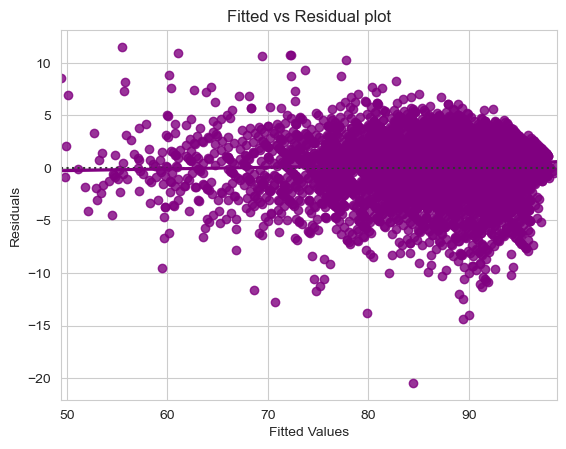

In [65]:
# let us plot the fitted values vs residuals
sns.set_style("whitegrid")
sns.residplot(
    data=df_pred, x="Fitted Values", y="Residuals", color="purple", lowess=True
)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residual plot")
plt.show()

## The above plot  of fitted values vs residuals don't follow any pattern (the curve is a straight line), then we say the model is almost linear. Achieving this can be a challenging task as perfect linear sometimes can be impossible. However, a near perfect linear like the above plot is achievable as they represent randomly distributed.


# Test for Normality

* Error terms/residuals should be normally distributed.

* If the error terms are not normally distributed, confidence intervals may become too wide or narrow. Once confidence interval becomes unstable, it leads to difficulty in estimating coefficients based on minimization of least squares.

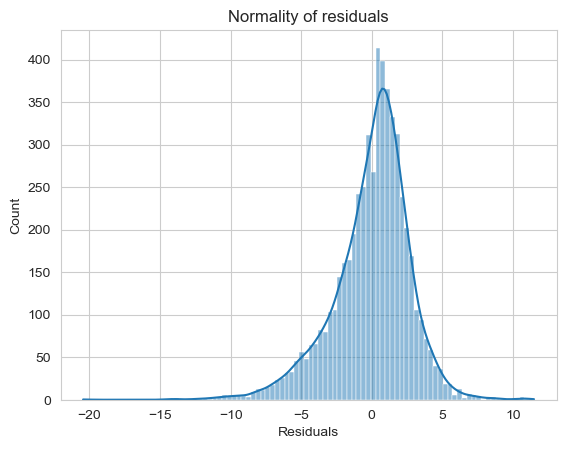

In [66]:
sns.histplot(df_pred["Residuals"], kde=True)
plt.title("Normality of residuals")
plt.show()

The above visual representation tells that the errors are normally distributed. It also suggests to some extent it is skewed towards its left. Since the model is built without outlier treatement considering the outliers are a legitamate values, the slight skewness could be a result of it. However, we will try soving the data with other approaches.

**The QQ plot of residuals can be used to visually check the normality assumption. The normal probability plot of residuals should approximately follow a straight line.**

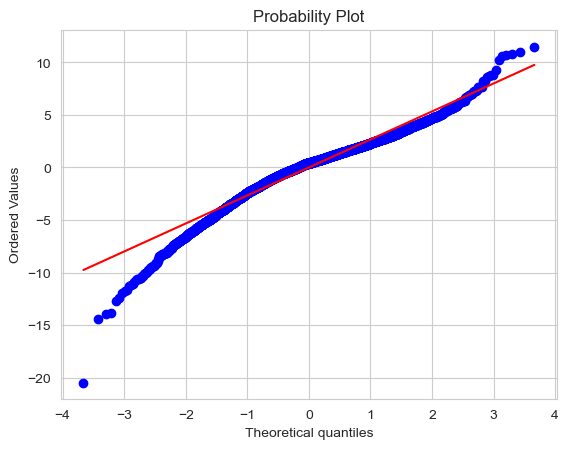

In [67]:
stats.probplot(df_pred["Residuals"], dist="norm", plot=pylab)
plt.show()

* Most of the points are lying on the straight line in QQ plot. There can be few exceptions as suggested earlier getting a full perfect model can be highly challenging especially without domain intervention. However, the above QQ plot could saticify the need.

The Shapiro-Wilk test can also be used for checking the normality. The null and alternate hypotheses of the test are as follows:

* Null hypothesis - Data is normally distributed.
* Alternate hypothesis - Data is not normally distributed.

In [68]:
stats.shapiro(df_pred["Residuals"])

ShapiroResult(statistic=0.9583057761192322, pvalue=3.9855000005047455e-37)

* Since p-value < 0.05, the residuals are not normal as per shapiro test.
* Strictly speaking - the residuals are not normal. However, as an approximation, we might be willing to accept this distribution as close to being normal

# TEST FOR HOMOSCEDASTICITY
**Homoscedacity** - If the variance of the residuals are symmetrically distributed across the regression line , then the data is said to homoscedastic.

**Heteroscedacity** - If the variance is unequal for the residuals across the regression line, then the data is said to be heteroscedastic. In this case the residuals can form an arrow shape or any other non symmetrical shape.


* The presence of non-constant variance in the error terms results in heteroscedasticity. Generally, non-constant variance arises in presence of outliers.

**How to check if model has Heteroscedasticity?**

* Can use the goldfeldquandt test. If we get p-value > 0.05 we can say that the residuals are homoscedastic, otherwise they are heteroscedastic.

**How to deal with Heteroscedasticity?**

* Can be fixed via adding other important features or making transformations.

The null and alternate hypotheses of the goldfeldquandt test are as follows:

* Null hypothesis : Residuals are homoscedastic
* Alternate hypothesis : Residuals have hetroscedasticity

In [69]:
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(df_pred["Residuals"], X_train)
lzip(name, test)

[('F statistic', 1.0234318275118257), ('p-value', 0.2717732010790733)]

* Since p-value > 0.05 we can say that the residuals are homoscedastic.

# Final Model

In [70]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    usr   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     4852.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:25:20   Log-Likelihood:                -13376.
No. Observations:                5528   AIC:                         2.678e+04
Df Residuals:                    5516   BIC:                         2.686e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   99.6746 

### Observations

* R-squared of the model is 0.906 and adjusted R-squared is 0.906, which shows that the model is able to explain ~90% variance in the data. This is quite phenomenal.

* A unit increase in the exec will result in a -0.2687 unit decrease in the usr, all other variables remaining constant.

* A unit increase in the independent variable will result in a const.  unit increase/decrease in the usr.

* The usr of a Not CPU Bound in runqsz will be -0.3178 units lesser than a runqsz of CPU Bound, all other variables remaining constant.

# Predictions, Linear Equation and RMSE score.

## Linear regression equation

In [71]:
# model parameters
ols.params

const                   99.674565
lread                   -0.011698
scall                   -0.001413
swrite                  -0.004938
exec                    -0.268674
rchar                   -0.000001
wchar                   -0.000005
ppgin                   -0.048955
vflt                    -0.024797
freemem                  0.000210
freeswap                -0.000001
runqsz_Not_CPU_Bound    -0.317823
dtype: float64

In [72]:
Equation = "usr ="
print(Equation, end=" ")
for i in range(len(X_train.columns)):
    if i == 0:
        print(ols.params[i], "+", end=" ")
    elif i != len(X_train.columns) - 1:
        print(
            ols.params[i],
            "* (",
            X_train.columns[i],
            ")",
            "+",
            end="  ",
        )
    else:
        print(ols.params[i], "* (", X_train.columns[i], ")")

usr = 99.67456476140191 + -0.011698042141953 * ( lread ) +  -0.0014128167946733641 * ( scall ) +  -0.004938179830042236 * ( swrite ) +  -0.2686742094564625 * ( exec ) +  -1.4794325809918855e-06 * ( rchar ) +  -5.134623999262638e-06 * ( wchar ) +  -0.04895505808532618 * ( ppgin ) +  -0.024796525604816134 * ( vflt ) +  0.0002103487045647368 * ( freemem ) +  -1.335542105397542e-06 * ( freeswap ) +  -0.3178231678893986 * ( runqsz_Not_CPU_Bound )


# Predictions on test data

In [73]:
X_train.columns

Index(['const', 'lread', 'scall', 'swrite', 'exec', 'rchar', 'wchar', 'ppgin',
       'vflt', 'freemem', 'freeswap', 'runqsz_Not_CPU_Bound'],
      dtype='object')

In [74]:
X_test.columns

Index(['const', 'lread', 'scall', 'swrite', 'exec', 'rchar', 'wchar', 'ppgin',
       'vflt', 'freemem', 'freeswap', 'runqsz_Not_CPU_Bound'],
      dtype='object')

In [75]:
# Predictions
y_pred = ols.predict(X_test)

In [76]:
# Check RMSE on the train data
rmse1 = np.sqrt(mean_squared_error(y_train, df_pred["Fitted Values"]))
rmse1

2.7203264821013207

In [77]:
# Check RMSE on the test data
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred))
rmse2

2.780337238168565

In [78]:
# check the MAE on the train data
mae1 = mean_absolute_error(y_train, df_pred["Fitted Values"])
mae1

2.0283333289650316

In [79]:
# check the MAE on the test data
mae2 = mean_absolute_error(y_test, y_pred)
mae2

2.033531020855098

* We can see that RMSE on the train and test sets are comparable. So, our model is not suffering from overfitting.
* MAE indicates that our current model is able to predict usr within a mean error of 2.0 units on the test data.
* Hence, we can conclude the model "ols" is good for prediction as well as inference purposes.

In [80]:
y_test

7285    94
875     84
3673    57
3166    97
3294    98
        ..
5639    93
2863    89
3691    91
2775    93
5423    84
Name: usr, Length: 2370, dtype: int64

In [81]:
y_pred_rounded = [round(val) for val in y_pred]
act_pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rounded})

In [82]:
act_pred_df = act_pred_df.reset_index(drop=True)

## Actual vs Predicted graph

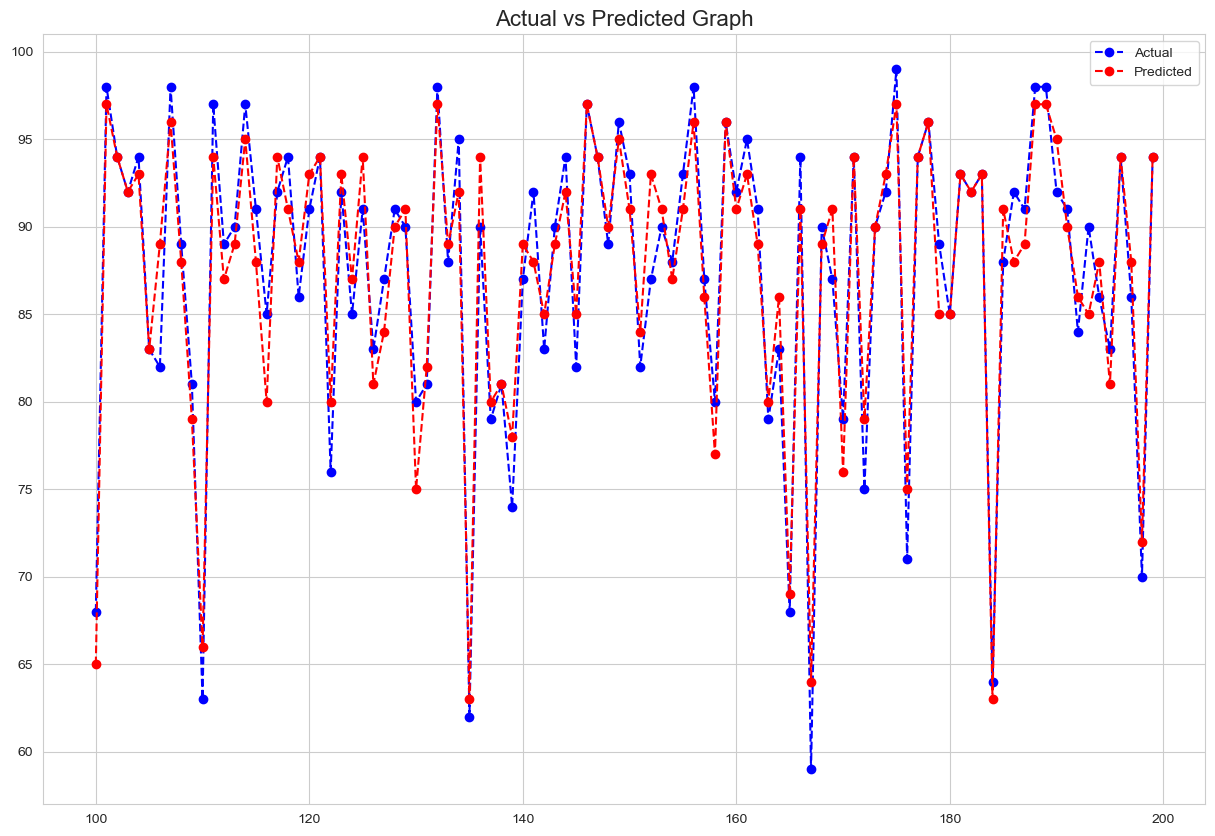

In [83]:
plt.figure(figsize=(15,10))
plt.plot(act_pred_df['Actual'][100:200], "c--o", label = "Actual ", c='blue')
plt.plot(act_pred_df['Predicted'][100:200], "m--o", label = "Predicted", c='Red')
plt.title("Actual vs Predicted Graph", fontsize=16)
plt.legend()
plt.show()

The above plot represents the Actual vs Predicted graph of a randomly choosen 100 records. The blue reprents the Actual records and the red represents the Predicted records. We can ne see a very minimal deviation when compared each other representing the model is doing a perfect job in predicting the values.

# Linear Regression using (sklearn)

In [84]:
#  'vflt', 'fork', 'ppgin'
X = data.drop(['usr', 'sread', 'fork', 'pflt', 'pgin', 'lwrite'], axis=1)
y = data['usr']

In [85]:
# let's add the intercept to data
X = sm.add_constant(X)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [87]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [88]:
# Let us explore the coefficients for each of the independent attributes
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

The coefficient for const is 0.0
The coefficient for lread is -0.011698042141955672
The coefficient for scall is -0.0014128167946733813
The coefficient for swrite is -0.0049381798300420394
The coefficient for exec is -0.2686742094564587
The coefficient for rchar is -1.4794325809921814e-06
The coefficient for wchar is -5.134623999262329e-06
The coefficient for ppgin is -0.048955058085327456
The coefficient for vflt is -0.02479652560481616
The coefficient for freemem is 0.00021034870456489721
The coefficient for freeswap is -1.3355421053992195e-06
The coefficient for runqsz_Not_CPU_Bound is -0.3178231678893766


In [89]:
# Let us check the intercept for the model

intercept = regression_model.intercept_

print("The intercept for our model is {}".format(intercept))

The intercept for our model is 99.67456476141315


In [90]:
# R square on training data
regression_model.score(X_train, y_train)

0.9063271600466553

90% of the variation in the usr is explained by the predictors in the model for train set

In [91]:
# R square on testing data
regression_model.score(X_test, y_test)

0.9030559276940191

90% of the variation in the usr is explained by the predictors in the model for test set

In [92]:
#RMSE on Training data
predicted_train=regression_model.fit(X_train, y_train).predict(X_train)
np.sqrt(metrics.mean_squared_error(y_train,predicted_train))

2.7203264821013207

In [93]:
#RMSE on Testing data
predicted_test=regression_model.fit(X_train, y_train).predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test,predicted_test))

2.780337238168478

# Approach 2
## Regularization

### Ridge

Ridge and Lasso regularization involve adding a penalty term to the linear regression cost function. These penalty terms are based on the magnitude of the coefficients, and they can be sensitive to the scale of the input features. Therefore, scaling is recommended to ensure that all features contribute equally to the regularization term.

In this approach let us consider zero to be valid inour data. Since regularization method does a feature selection part within it, may be the variables with large zero will be punished in the pressence of lambda (alpha) function.

In [94]:
new_df['runqsz'] = pd.Categorical(new_df['runqsz'])

In [95]:
new_data = pd.get_dummies(new_df, columns=["runqsz"], drop_first=True)
new_data

lread  lwrite  scall  sread  swrite  fork  exec     rchar    wchar  \
0         1       0   2147     79      68   0.2  0.20   40671.0  53995.0   
1         0       0    170     18      21   0.2  0.20     448.0   8385.0   
2        15       3   2162    159     119   2.0  2.40       NaN  31950.0   
3         0       0    160     12      16   0.2  0.20       NaN   8670.0   
4         5       1    330     39      38   0.4  0.40       NaN  12185.0   
...     ...     ...    ...    ...     ...   ...   ...       ...      ...   
7893     16      12   3009    360     244   1.6  5.81  405250.0  85282.0   
7894      4       0   1596    170     146   2.4  1.80   89489.0  41764.0   
7895     16       5   3116    289     190   0.6  0.60  325948.0  52640.0   
7896     32      45   5180    254     179   1.2  1.20   62571.0  29505.0   
7897      2       0    985     55      46   1.6  4.80  111111.0  22256.0   

      pgout  ...  pgfree  atch   pgin  ppgin    pflt    vflt  freemem  \
0      0.00  ...    0.00   0.0   1.60   2.60   16.00   26.40     4670   
1      0.00  ...    0.00   0.0   0.00   0.00   15.63   16.83     7278   
2      0.00  ...    0.00   1.2   6.00   9.40  150.20  220.20      702   
3      0.00  ...    0.00   0.0   0.20   0.20   15.60   16.80     7248   
4      0.00  ...    0.00   0.0   1.00   1.20   37.80   47.60      633   
...     ...  ...     ...   ...    ...    ...     ...     ...      ...   
7893   8.02  ...   43.69   0.6  35.87  47.90  139.28  270.74      387   
7894   3.80  ...    4.80   0.8   3.80   4.40  122.40  212.60      263   
7895   0.40  ...    0.60   0.4  28.40  45.20   60.20  219.80      400   
7896   1.40  ...   13.03   0.4  23.05  24.25   93.19  202.81      141   
7897   0.00  ...    0.00   0.2   3.40   6.20   91.80  110.00      659   

      freeswap  usr  runqsz_Not_CPU_Bound  
0      1730946   95                     0  
1      1869002   97                     1  
2      1021237   87                     1  
3      1863704   98                     1  
4      1760253   90                     1  
...        ...  ...                   ...  
7893    986647   80                     0  
7894   1055742   90                     1  
7895    969106   87                     1  
7896   1022458   83                     0  
7897   1756514   94                     0  

[7898 rows x 21 columns]

In [96]:
X = new_data.drop(['usr'], axis=1)
y = new_data['usr']

In [97]:
knn_imputer = KNNImputer()
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

# Combining imputed features with the target column
df_imputed = pd.concat([X_imputed, y], axis=1)

In [98]:
X = df_imputed.drop(['usr'], axis=1)
y = df_imputed['usr']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [100]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define a range of alpha values to try
ridge_param_grid = {'ridge__alpha': np.logspace(-4, 4, 9)}

# Use GridSearchCV for Ridge regression
ridge_grid_search = GridSearchCV(ridge_pipeline, param_grid=ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
             scoring='neg_mean_squared_error')

In [101]:
print("Best alpha for Ridge: {}".format(ridge_grid_search.best_params_['ridge__alpha']))

Best alpha for Ridge: 10.0


In [102]:
best_alpha = ridge_grid_search.best_params_['ridge__alpha']
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

Ridge(alpha=10.0)

In [103]:
ridge_model.coef_

array([-1.14609716e-02, -1.51953217e-03, -1.37268438e-03,  2.59741251e-04,
       -5.56726724e-03,  1.15723257e-01, -2.94591203e-01, -1.52368958e-06,
       -4.39474591e-06, -1.15191167e-01,  1.39208753e-02, -6.22037122e-03,
       -1.28117255e-02, -2.36688534e-02, -3.49034940e-02, -1.89978470e-02,
       -1.40758887e-02,  1.76277912e-04, -9.30074131e-07, -2.32147365e-01])

In [104]:
y_train_pred = ridge_model.predict(X_train)

In [105]:
y_test_pred = ridge_model.predict(X_test)

In [106]:
print(ridge_model.score(X_train, y_train))
print(ridge_model.score(X_test, y_test))

0.9152828363177401
0.9093091434469945


In [107]:
rmse1 = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("The Root Mean Squared Error on Train Set: {}".format(rmse1))

The Root Mean Squared Error on Train Set: 2.587020614213069


In [108]:
rmse2 = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("The Root Mean Squared Error on Test Set: {}".format(rmse2))

The Root Mean Squared Error on Test Set: 2.6891721118726006


In [109]:
y_pred_rounded_ridge = [round(val) for val in y_test_pred]
act_pred_ridge_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rounded_ridge})

In [110]:
act_pred_ridge_df

Actual  Predicted
7285      94         96
875       84         84
3673      57         62
3166      97         97
3294      98         97
...      ...        ...
5639      93         94
2863      89         86
3691      91         88
2775      93         92
5423      84         85

[2370 rows x 2 columns]

In [111]:
act_pred_ridge_df = act_pred_ridge_df.reset_index(drop=True)

## Actual vs Predicted graph

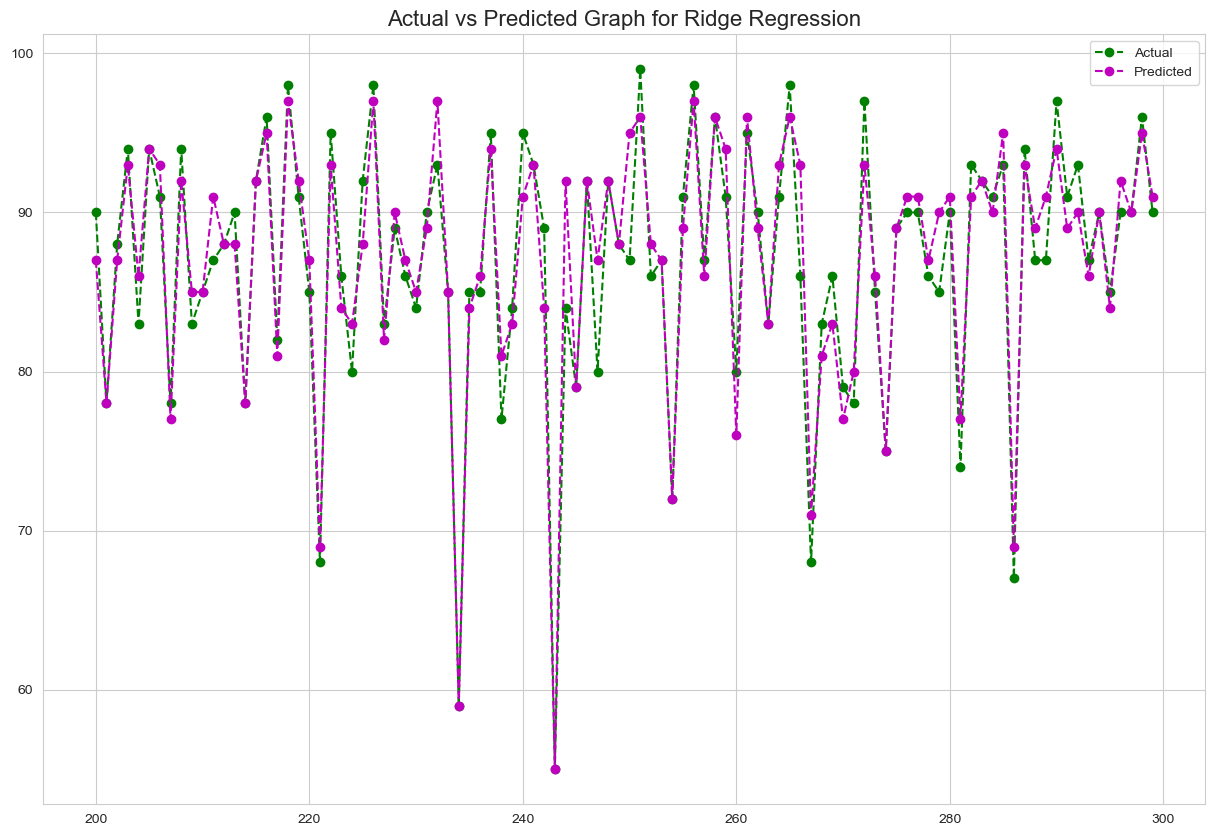

In [112]:
plt.figure(figsize=(15,10))
plt.plot(act_pred_ridge_df['Actual'][200:300], "c--o", label = "Actual ", c='green')
plt.plot(act_pred_ridge_df['Predicted'][200:300], "m--o", label = "Predicted", c='m')
plt.title("Actual vs Predicted Graph for Ridge Regression", fontsize=16)
plt.legend()
plt.show()

The above plot represents the Actual vs Predicted graph of a randomly choosen 100 records for the ridge model. The green reprents the Actual records and the megenta represents the Predicted records. We can ne see a very minimal deviation when compared each other representing the model is doing a perfect job in predicting the values.

### Lasso

In [113]:
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# Define a range of alpha values to try
lasso_param_grid = {'lasso__alpha': np.logspace(-4, 4, 9)}

# Use GridSearchCV for Ridge regression
lasso_grid_search = GridSearchCV(lasso_pipeline, param_grid=lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
             scoring='neg_mean_squared_error')

In [114]:
print("Best alpha for Lasso: {}".format(lasso_grid_search.best_params_['lasso__alpha']))

Best alpha for Lasso: 0.01


In [115]:
best_alpha = lasso_grid_search.best_params_['lasso__alpha']
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.01)

In [116]:
lasso_model.coef_

array([-1.14262639e-02, -1.55576264e-03, -1.37144293e-03,  2.48161587e-04,
       -5.49907366e-03,  8.16605202e-02, -2.90166772e-01, -1.51689204e-06,
       -4.39819061e-06, -1.12618615e-01,  1.22669263e-02, -5.96646722e-03,
       -1.25729506e-02, -2.39173321e-02, -3.48325216e-02, -1.88102008e-02,
       -1.38312026e-02,  1.73841909e-04, -8.84754104e-07, -1.84028919e-01])

In [117]:
y_train_pred = lasso_model.predict(X_train)

In [118]:
y_test_pred = lasso_model.predict(X_test)

In [119]:
print(lasso_model.score(X_train, y_train))
print(lasso_model.score(X_test, y_test))

0.9152708482960568
0.9093835593687756


In [120]:
rmse1 = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("The Root Mean Squared Error on Train Set: {}".format(rmse1))

The Root Mean Squared Error on Train Set: 2.587203647737826


In [121]:
rmse2 = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("The Root Mean Squared Error on Test Set: {}".format(rmse2))

The Root Mean Squared Error on Test Set: 2.6880685921944107


In [122]:
y_pred_rounded_lasso = [round(val) for val in y_test_pred]
act_pred_lasso_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rounded_lasso})

In [123]:
act_pred_lasso_df

Actual  Predicted
7285      94         96
875       84         84
3673      57         62
3166      97         97
3294      98         97
...      ...        ...
5639      93         94
2863      89         86
3691      91         88
2775      93         92
5423      84         85

[2370 rows x 2 columns]

In [124]:
act_pred_lasso_df = act_pred_lasso_df.reset_index(drop=True)

## Actual vs Predicted graph

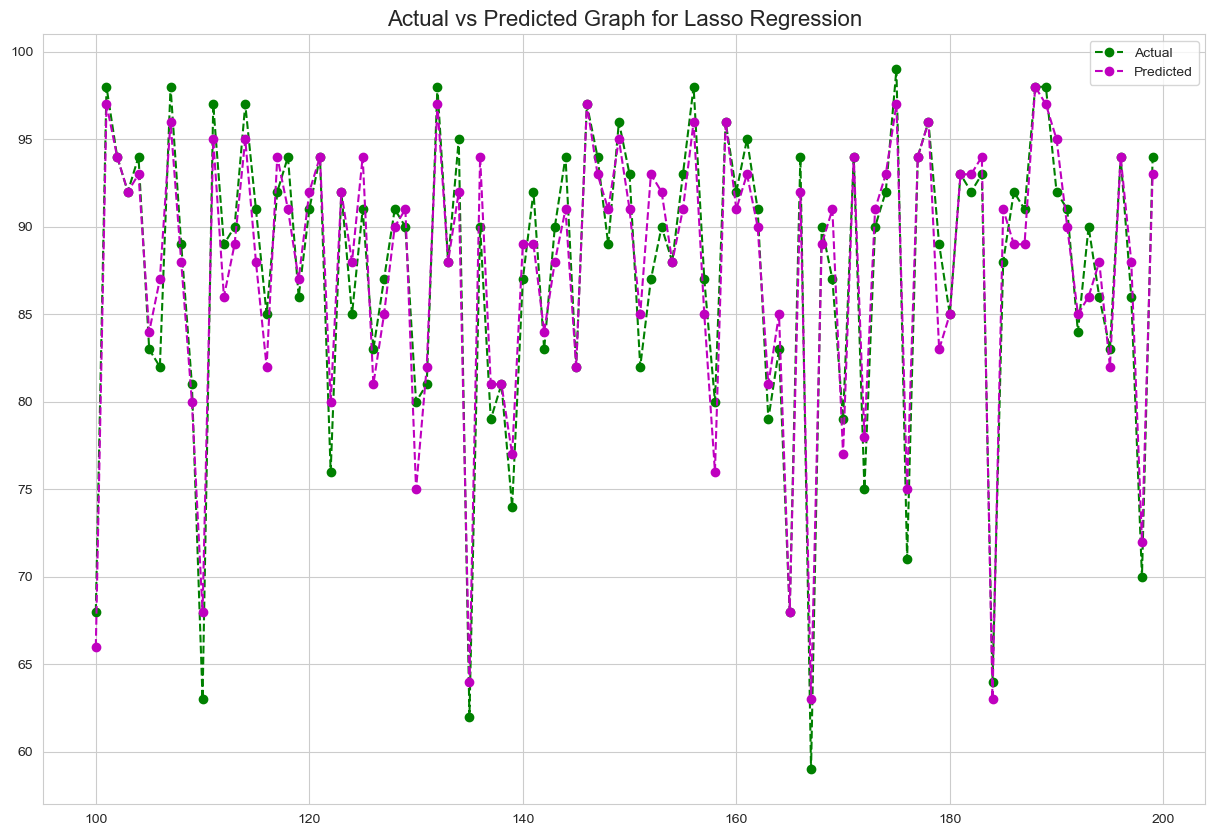

In [125]:
plt.figure(figsize=(15,10))
plt.plot(act_pred_lasso_df['Actual'][100:200], "c--o", label = "Actual ", c='green')
plt.plot(act_pred_lasso_df['Predicted'][100:200], "m--o", label = "Predicted", c='m')
plt.title("Actual vs Predicted Graph for Lasso Regression", fontsize=16)
plt.legend()
plt.show()

The above plot represents the Actual vs Predicted graph of a randomly choosen 100 records for the lasso model. The green reprents the Actual records and the megenta represents the Predicted records. We can ne see a very minimal deviation when compared each other representing the model is doing a perfect job in predicting the values.

# Approach 3

EDA evidentally displays that there is a skewness in the data that too almost all variables having their values skewed towards right. Another approach of building the model would be by log transformation also not excluding the columns with significant number of zeros except "pgscan"

In [126]:
df2 = df.copy()
df2

lread  lwrite  scall  sread  swrite  fork  exec     rchar    wchar  \
0         1       0   2147     79      68   0.2  0.20   40671.0  53995.0   
1         0       0    170     18      21   0.2  0.20     448.0   8385.0   
2        15       3   2162    159     119   2.0  2.40       NaN  31950.0   
3         0       0    160     12      16   0.2  0.20       NaN   8670.0   
4         5       1    330     39      38   0.4  0.40       NaN  12185.0   
...     ...     ...    ...    ...     ...   ...   ...       ...      ...   
8187     16      12   3009    360     244   1.6  5.81  405250.0  85282.0   
8188      4       0   1596    170     146   2.4  1.80   89489.0  41764.0   
8189     16       5   3116    289     190   0.6  0.60  325948.0  52640.0   
8190     32      45   5180    254     179   1.2  1.20   62571.0  29505.0   
8191      2       0    985     55      46   1.6  4.80  111111.0  22256.0   

      pgout  ...  pgfree  atch   pgin  ppgin    pflt    vflt         runqsz  \
0      0.00  ...    0.00   0.0   1.60   2.60   16.00   26.40      CPU_Bound   
1      0.00  ...    0.00   0.0   0.00   0.00   15.63   16.83  Not_CPU_Bound   
2      0.00  ...    0.00   1.2   6.00   9.40  150.20  220.20  Not_CPU_Bound   
3      0.00  ...    0.00   0.0   0.20   0.20   15.60   16.80  Not_CPU_Bound   
4      0.00  ...    0.00   0.0   1.00   1.20   37.80   47.60  Not_CPU_Bound   
...     ...  ...     ...   ...    ...    ...     ...     ...            ...   
8187   8.02  ...   43.69   0.6  35.87  47.90  139.28  270.74      CPU_Bound   
8188   3.80  ...    4.80   0.8   3.80   4.40  122.40  212.60  Not_CPU_Bound   
8189   0.40  ...    0.60   0.4  28.40  45.20   60.20  219.80  Not_CPU_Bound   
8190   1.40  ...   13.03   0.4  23.05  24.25   93.19  202.81      CPU_Bound   
8191   0.00  ...    0.00   0.2   3.40   6.20   91.80  110.00      CPU_Bound   

     freemem  freeswap  usr  
0       4670   1730946   95  
1       7278   1869002   97  
2        702   1021237   87  
3       7248   1863704   98  
4        633   1760253   90  
...      ...       ...  ...  
8187     387    986647   80  
8188     263   1055742   90  
8189     400    969106   87  
8190     141   1022458   83  
8191     659   1756514   94  

[8192 rows x 21 columns]

### Converting categorical to numerical category

In [127]:
df2['runqsz'] = pd.Categorical(df2['runqsz'])

In [128]:
df2 = pd.get_dummies(df2, columns=["runqsz"], drop_first=True)

### NaN value Treatment

In [129]:
# Separate features and target
X = df2.drop(['usr'], axis=1)
y = df2[['usr']]

In [130]:
knn_imputer = KNNImputer()
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

# Combining imputed features with the target column
df2_imputed = pd.concat([X_imputed, y], axis=1)

In [131]:
left_skewed_features = df2_imputed.drop(['usr', 'runqsz_Not_CPU_Bound'], axis=1)
for feature in left_skewed_features:
    df2_imputed[feature] = np.log1p(df2_imputed[feature])

In [132]:
df2_imputed

lread    lwrite     scall     sread    swrite      fork      exec  \
0     0.693147  0.000000  7.672292  4.382027  4.234107  0.182322  0.182322   
1     0.000000  0.000000  5.141664  2.944439  3.091042  0.182322  0.182322   
2     2.772589  1.386294  7.679251  5.075174  4.787492  1.098612  1.223775   
3     0.000000  0.000000  5.081404  2.564949  2.833213  0.182322  0.182322   
4     1.791759  0.693147  5.802118  3.688879  3.663562  0.336472  0.336472   
...        ...       ...       ...       ...       ...       ...       ...   
8187  2.833213  2.564949  8.009695  5.888878  5.501258  0.955511  1.918392   
8188  1.609438  0.000000  7.375882  5.141664  4.990433  1.223775  1.029619   
8189  2.833213  1.791759  8.044626  5.669881  5.252273  0.470004  0.470004   
8190  3.496508  3.828641  8.552753  5.541264  5.192957  0.788457  0.788457   
8191  1.098612  0.000000  6.893656  4.025352  3.850148  0.955511  1.757858   

          rchar      wchar     pgout  ...    pgfree      atch      pgin  \
0     10.613295  10.896665  0.000000  ...  0.000000  0.000000  0.955511   
1      6.107023   9.034319  0.000000  ...  0.000000  0.000000  0.000000   
2     11.916048  10.371959  0.000000  ...  0.000000  0.788457  1.945910   
3     12.144015   9.067739  0.000000  ...  0.000000  0.000000  0.182322   
4     10.244165   9.408043  0.000000  ...  0.000000  0.000000  0.693147   
...         ...        ...       ...  ...       ...       ...       ...   
8187  12.912262  11.353730  2.199444  ...  3.799750  0.470004  3.607398   
8188  11.401882  10.639814  1.568616  ...  1.757858  0.587787  1.568616   
8189  12.694496  10.871251  0.336472  ...  0.470004  0.336472  3.380995   
8190  11.044073  10.292349  0.875469  ...  2.641198  0.336472  3.180135   
8191  11.618294  10.010412  0.000000  ...  0.000000  0.182322  1.481605   

         ppgin      pflt      vflt   freemem   freeswap  runqsz_Not_CPU_Bound  \
0     1.280934  2.833213  3.310543  8.449128  14.364179                   0.0   
1     0.000000  2.811208  2.880882  8.892749  14.440916                   1.0   
2     2.341806  5.018603  5.399067  6.555357  13.836526                   1.0   
3     0.182322  2.809403  2.879198  8.888619  14.438077                   1.0   
4     0.788457  3.658420  3.883624  6.452049  14.380969                   1.0   
...        ...       ...       ...       ...        ...                   ...   
8187  3.889777  4.943640  5.604846  5.961005  13.802069                   0.0   
8188  1.686399  4.815431  5.364105  5.575949  13.869755                   1.0   
8189  3.832980  4.114147  5.397257  5.993961  13.784130                   1.0   
8190  3.228826  4.545314  5.317188  4.955827  13.837721                   0.0   
8191  1.974081  4.530447  4.709530  6.492240  14.378842                   0.0   

      usr  
0      95  
1      97  
2      87  
3      98  
4      90  
...   ...  
8187   80  
8188   90  
8189   87  
8190   83  
8191   94  

[8192 rows x 21 columns]

In [133]:
#  'vflt', 'fork', 'ppgin'
X = df2_imputed.drop('usr', axis=1)
y = df2_imputed['usr']

In [134]:
# let's add the intercept to data
X = sm.add_constant(X)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [136]:
olsmod = sm.OLS(y_train, X_train)
ols = olsmod.fit()

In [137]:
print(ols.summary())    

                            OLS Regression Results                            
Dep. Variable:                    usr   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     6087.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:25:27   Log-Likelihood:                -15945.
No. Observations:                5734   AIC:                         3.193e+04
Df Residuals:                    5713   BIC:                         3.207e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.0523 

### SInce there is a presence of strong multicollinearity we would look to solve it using VIF

In [138]:
vif_series1 = pd.Series(
    [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
    index=X_train.columns,
)
print("VIF values: \n\n{}\n".format(vif_series1))

VIF values: 

const                   329.862868
lread                     6.034127
lwrite                    4.333979
scall                     5.149132
sread                     9.416730
swrite                    7.976607
fork                     10.351334
exec                      4.182452
rchar                     2.801661
wchar                     1.965367
pgout                    19.781849
ppgout                   62.951259
pgfree                   31.731043
atch                      1.620914
pgin                     28.608188
ppgin                    28.925406
pflt                     11.909495
vflt                     12.524856
freemem                   2.715459
freeswap                  1.317787
runqsz_Not_CPU_Bound      1.198505
dtype: float64



In [139]:
X_train2 = X_train.drop(["ppgout"], axis=1)
olsmod_1 = sm.OLS(y_train, X_train2)
olsres_1 = olsmod_1.fit()
print(
    "R-squared:",
    np.round(olsres_1.rsquared, 3),
    "\nAdjusted R-squared:",
    np.round(olsres_1.rsquared_adj, 3),
)

R-squared: 0.955 
Adjusted R-squared: 0.955


In [140]:
X_train3 = X_train.drop("ppgout", axis=1)
olsmod = sm.OLS(y_train, X_train3)
ols = olsmod.fit()

In [141]:
print(ols.summary())    

                            OLS Regression Results                            
Dep. Variable:                    usr   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     6403.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:25:27   Log-Likelihood:                -15947.
No. Observations:                5734   AIC:                         3.193e+04
Df Residuals:                    5714   BIC:                         3.207e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.2065 

In [142]:
vif_series1 = pd.Series(
    [variance_inflation_factor(X_train3.values, i) for i in range(X_train3.shape[1])],
    index=X_train3.columns,
)
print("VIF values: \n\n{}\n".format(vif_series1))

VIF values: 

const                   327.857466
lread                     5.994686
lwrite                    4.317841
scall                     5.148210
sread                     9.416409
swrite                    7.975863
fork                     10.350771
exec                      4.177361
rchar                     2.801414
wchar                     1.960213
pgout                     8.936931
pgfree                    8.890582
atch                      1.617038
pgin                     28.579591
ppgin                    28.890358
pflt                     11.908040
vflt                     12.504643
freemem                   2.701845
freeswap                  1.317424
runqsz_Not_CPU_Bound      1.198208
dtype: float64



In [143]:
X_train2 = X_train3.drop(["ppgin"], axis=1)
olsmod_1 = sm.OLS(y_train, X_train2)
olsres_1 = olsmod_1.fit()
print(
    "R-squared:",
    np.round(olsres_1.rsquared, 3),
    "\nAdjusted R-squared:",
    np.round(olsres_1.rsquared_adj, 3),
)

R-squared: 0.955 
Adjusted R-squared: 0.955


In [144]:
X_train4 = X_train.drop(['ppgout','pgout', 'sread', 'ppgin', 'vflt'], axis=1)
vif_series1 = pd.Series(
    [variance_inflation_factor(X_train4.values, i) for i in range(X_train4.shape[1])],
    index=X_train4.columns,
)
print("VIF values: \n\n{}\n".format(vif_series1))

VIF values: 

const                   311.914154
lread                     5.910736
lwrite                    4.278777
scall                     4.401986
swrite                    5.072730
fork                      9.878811
exec                      4.169823
rchar                     2.088783
wchar                     1.913347
pgfree                    2.346769
atch                      1.443857
pgin                      1.809327
pflt                      7.467116
freemem                   2.651224
freeswap                  1.307257
runqsz_Not_CPU_Bound      1.192371
dtype: float64



In [145]:
olsmod = sm.OLS(y_train, X_train4)
ols = olsmod.fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    usr   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     7862.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:25:27   Log-Likelihood:                -16034.
No. Observations:                5734   AIC:                         3.210e+04
Df Residuals:                    5718   BIC:                         3.221e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.7840 

# The notes section too does not imply presence of multicollinearity

## P-value check for imporatnce of variables with respect to the target

In [146]:
X_train5 = X_train4.drop(['lwrite', 'atch'], axis=1)
olsmod = sm.OLS(y_train, X_train5)
ols = olsmod.fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    usr   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     9073.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:25:28   Log-Likelihood:                -16035.
No. Observations:                5734   AIC:                         3.210e+04
Df Residuals:                    5720   BIC:                         3.219e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.7907 

### THe above OLS model indicate all the variables p-values are < 0.05. Indicating the importance of features and its contribution towards the target

# Linearity and Independence test 

* Linearity describes a straight-line relationship between two variables, predictor variables must have a linear relation with the dependent variable.

**How to check linearity?**

* Make a plot of fitted values vs residuals. If they don't follow any pattern (the curve is a straight line), then we say the model is linear otherwise model is showing signs of non-linearity.


In [147]:
df_pred = pd.DataFrame()

df_pred["Actual Values"] = y_train.values.flatten()  # actual values
df_pred["Fitted Values"] = ols.fittedvalues.values  # predicted values
df_pred["Residuals"] = ols.resid.values  # residuals

df_pred.head()

Actual Values  Fitted Values  Residuals
0             94      96.840681  -2.840681
1             93      94.751706  -1.751706
2             94      90.497646   3.502354
3             89      95.124350  -6.124350
4             89      85.875447   3.124553

## The above plot  of fitted values vs residuals don't follow any pattern (the curve is a straight line), then we say the model is almost linear. Achieving this can be a challenging task as perfect linear sometimes can be impossible. However, a near perfect linear like the above plot is achievable as they represent randomly distributed.


# Test for Normality

* Error terms/residuals should be normally distributed.

* If the error terms are not normally distributed, confidence intervals may become too wide or narrow. Once confidence interval becomes unstable, it leads to difficulty in estimating coefficients based on minimization of least squares.

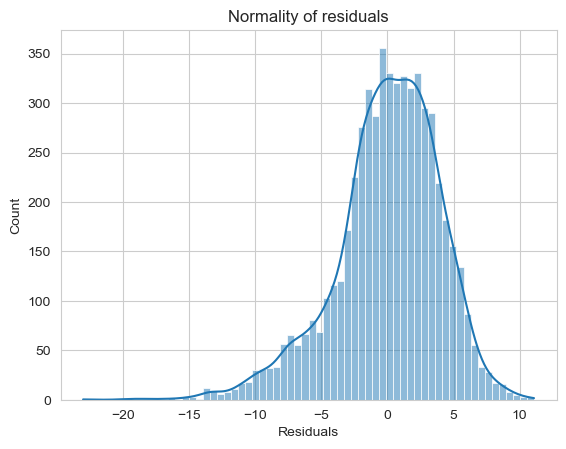

In [148]:
sns.histplot(df_pred["Residuals"], kde=True)
plt.title("Normality of residuals")
plt.show()

The above visual representation tells that the errors are normally distributed. It also suggests to some extent it is skewed towards its left. Since the model is built without outlier treatement considering the outliers are a legitamate values, the slight skewness could be a result of it. 

**The QQ plot of residuals can be used to visually check the normality assumption. The normal probability plot of residuals should approximately follow a straight line.**

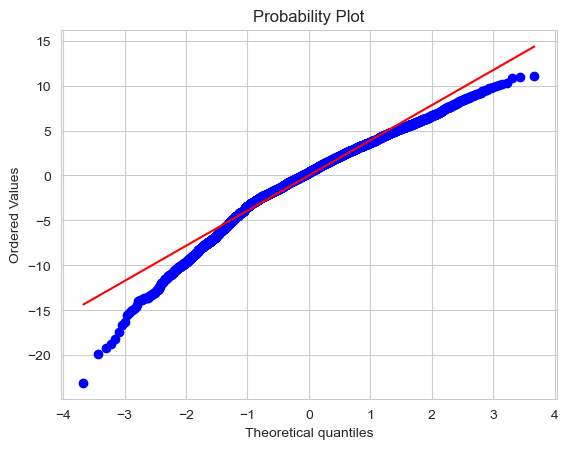

In [149]:
stats.probplot(df_pred["Residuals"], dist="norm", plot=pylab)
plt.show()

* Most of the points are lying on the straight line in QQ plot. There can be few exceptions as suggested earlier getting a full perfect model can be highly challenging especially without domain intervention. However, the above QQ plot could saticify the need.

The Shapiro-Wilk test can also be used for checking the normality. The null and alternate hypotheses of the test are as follows:

* Null hypothesis - Data is normally distributed.
* Alternate hypothesis - Data is not normally distributed.

In [150]:
stats.shapiro(df_pred["Residuals"])

ShapiroResult(statistic=0.9707033634185791, pvalue=1.1240551588406858e-32)

* Since p-value < 0.05, the residuals are not normal as per shapiro test.
* Strictly speaking - the residuals are not normal. However, as an approximation, we might be willing to accept this distribution as close to being normal

# TEST FOR HOMOSCEDASTICITY
**Homoscedacity** - If the variance of the residuals are symmetrically distributed across the regression line , then the data is said to homoscedastic.

**Heteroscedacity** - If the variance is unequal for the residuals across the regression line, then the data is said to be heteroscedastic. In this case the residuals can form an arrow shape or any other non symmetrical shape.


* The presence of non-constant variance in the error terms results in heteroscedasticity. Generally, non-constant variance arises in presence of outliers.

**How to check if model has Heteroscedasticity?**

* Can use the goldfeldquandt test. If we get p-value > 0.05 we can say that the residuals are homoscedastic, otherwise they are heteroscedastic.

**How to deal with Heteroscedasticity?**

* Can be fixed via adding other important features or making transformations.

The null and alternate hypotheses of the goldfeldquandt test are as follows:

* Null hypothesis : Residuals are homoscedastic
* Alternate hypothesis : Residuals have hetroscedasticity

In [151]:
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(df_pred["Residuals"], X_train5)
lzip(name, test)

[('F statistic', 0.9257067737419702), ('p-value', 0.9803610645151454)]

* Since p-value > 0.05 we can say that the residuals are homoscedastic.

In [152]:
Equation = "usr ="
print(Equation, end=" ")
for i in range(len(X_train5.columns)):
    if i == 0:
        print(ols.params[i], "+", end=" ")
    elif i != len(X_train5.columns) - 1:
        print(
            ols.params[i],
            "* (",
            X_train5.columns[i],
            ")",
            "+",
            end="  ",
        )
    else:
        print(ols.params[i], "* (", X_train5.columns[i], ")")

usr = 10.79066194018088 + -0.25875287004735215 * ( lread ) +  -1.003750754666622 * ( scall ) +  -0.8994804714415646 * ( swrite ) +  -8.919499626253222 * ( fork ) +  -1.121453372485893 * ( exec ) +  -0.15480565997645684 * ( rchar ) +  -0.5127756779926893 * ( wchar ) +  -0.8874788958882674 * ( pgfree ) +  -0.7241704102796112 * ( pgin ) +  1.4158098312109855 * ( pflt ) +  -0.8965852086641317 * ( freemem ) +  7.490463236610244 * ( freeswap ) +  0.6363907112824582 * ( runqsz_Not_CPU_Bound )


# Predictions on test data

In [153]:
X_train5.columns

Index(['const', 'lread', 'scall', 'swrite', 'fork', 'exec', 'rchar', 'wchar',
       'pgfree', 'pgin', 'pflt', 'freemem', 'freeswap',
       'runqsz_Not_CPU_Bound'],
      dtype='object')

In [154]:
X_test.columns

Index(['const', 'lread', 'lwrite', 'scall', 'sread', 'swrite', 'fork', 'exec',
       'rchar', 'wchar', 'pgout', 'ppgout', 'pgfree', 'atch', 'pgin', 'ppgin',
       'pflt', 'vflt', 'freemem', 'freeswap', 'runqsz_Not_CPU_Bound'],
      dtype='object')

In [155]:
X_test2 = X_test.drop(
    ['lwrite', 'sread', 'pgout', 'ppgout', 'atch', 'ppgin', 'vflt'], axis=1
)

In [156]:
# Predictions
y_pred = ols.predict(X_test2)

In [157]:
# Check RMSE on the train data
rmse1 = np.sqrt(mean_squared_error(y_train, df_pred["Fitted Values"]))
rmse1

3.965124845143364

In [158]:
# Check RMSE on the test data
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred))
rmse2

3.9354229764644773

In [159]:
# check the MAE on the train data
mae1 = mean_absolute_error(y_train, df_pred["Fitted Values"])
mae1

3.0475993791394114

In [160]:
# check the MAE on the test data
mae2 = mean_absolute_error(y_test, y_pred)
mae2

3.0323486562705573

* We can see that RMSE on the train and test sets are comparable. So, our model is not suffering from overfitting.
* MAE indicates that our current model is able to predict usr within a mean error of 2.0 units on the test data.
* Hence, we can conclude the model "ols" is good for prediction as well as inference purposes.

In [161]:
y_test

3566    83
899     87
2406    85
5447    92
6215    95
        ..
7258    89
2705    81
6554    88
6551    92
6545    92
Name: usr, Length: 2458, dtype: int64

In [162]:
y_pred_rounded = [round(val) for val in y_pred]
act_pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rounded})

In [163]:
act_pred_df = act_pred_df.reset_index(drop=True)

## Actual vs Predicted graph

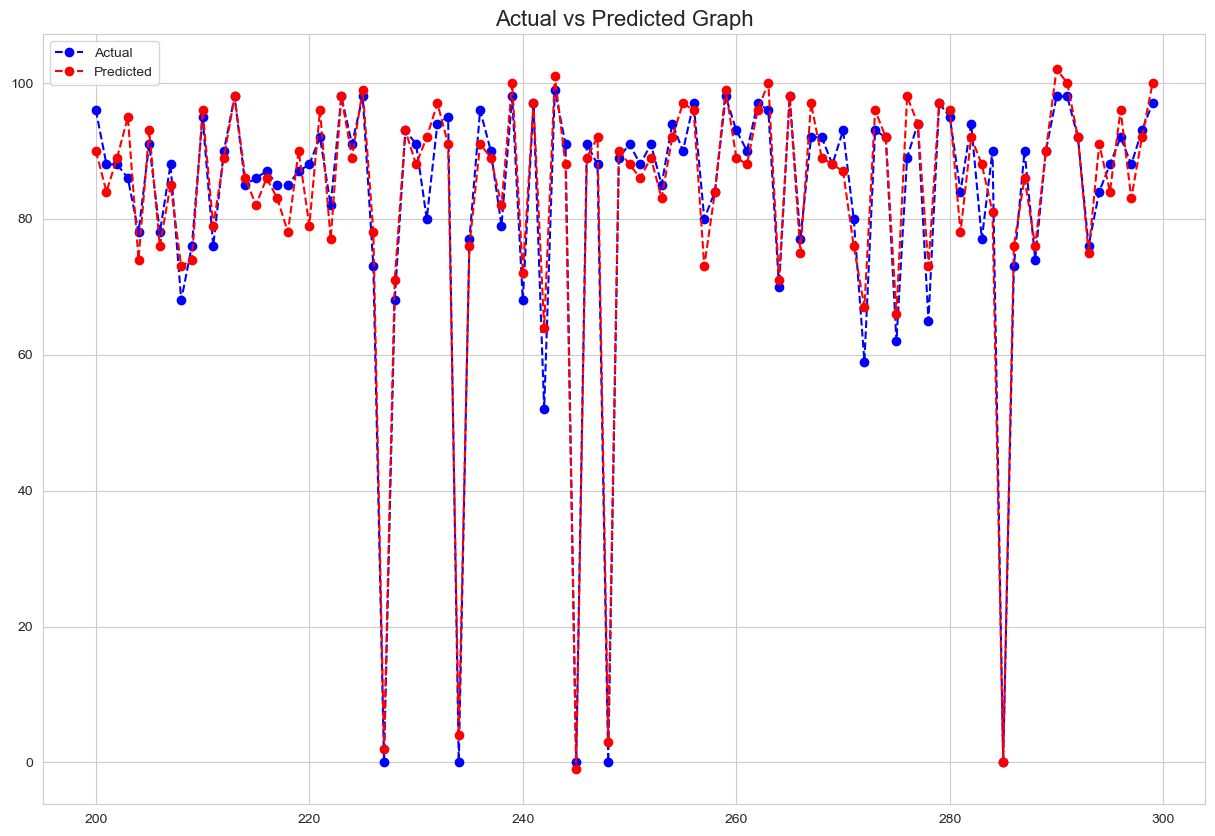

In [164]:
plt.figure(figsize=(15,10))
plt.plot(act_pred_df['Actual'][200:300], "c--o", label = "Actual ", c='blue')
plt.plot(act_pred_df['Predicted'][200:300], "m--o", label = "Predicted", c='Red')
plt.title("Actual vs Predicted Graph", fontsize=16)
plt.legend()
plt.show()

The above plot represents the Actual vs Predicted graph of a randomly choosen 100 records. The blue reprents the Actual records and the red represents the Predicted records. We can ne see a very minimal deviation when compared each other representing the model is doing a perfect job in predicting the values.